# Introduction

The dataset consists of Corporate credit card transactions published by the London Borough of Barnet for different time
periods.

The following assumptions are to be made:
- Service Area denotes the functional areas (org chart) within the Borough of Barnett
- Account Description is the name of the general ledger account in which each transaction is recorded.
- Assume that Journal Date and Transaction Date are synonymous
- Disregard JV Date
- Assume Total and JV Value are synonymous; these are the amount of each transaction


In [1]:
# Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dash import Dash, dcc, html, Output, Input
import plotly.express as px

from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings("ignore")


### Data Preprocessing

* In this section we obtain all the data from different sources and form one unified dataset that contains all relevant records.
* We clean the dataset, by removing irrelevant columns and values.

In [2]:
ds = pd.read_csv('Data/1718Pcard.csv') #We have to handle this dataset as well
ds1 = pd.read_csv('Data/PCard 1617.csv')
ds2 = pd.read_csv('Data/PCard Transactions 15-16.txt')
ds3 = pd.read_csv('Data/Purchasing Card Data 2014 v1.csv')

In [4]:
ds1.columns,ds2.columns,ds3.columns

(Index(['Service Area', 'Account Description', 'Creditor', 'Journal Date',
        'Journal Reference', 'Total'],
       dtype='object'),
 Index(['Service Area', 'Account Description', 'Creditor', 'Journal Date',
        'Journal Reference', 'Total'],
       dtype='object'),
 Index(['Service Area', 'Account Description', 'Creditor', 'Transaction Date',
        'JV Reference', 'JV Date', 'JV Value'],
       dtype='object'))

In [5]:
ds.columns 

Index(['FIN.TRANSACTION DATE', 'FIN.POSTING DATE', 'FIN.TRANSACTION AMOUNT',
       'MCH.MERCHANT NAME', 'MCH.CITY NAME', 'FIN.ORIGINAL CURRENCY AMOUNT',
       'FIN.ORIGINAL ISO CURRENCY CODE SYMBOL', 'FIN.INET CONVERSION'],
      dtype='object')

Observations:
- From the columns list we can conclude that ds1,ds2 and ds3 are following the schema rules, but ds is not. So we can create a common dataset using ds1, ds2 and ds3 for our analysis.
- We also have to drop and rename certain columns based on assumptions provided.

In [3]:
ds3.rename(columns={'Transaction Date':'Journal Date','JV Value':'Total','JV Reference':'Journal Reference'}, inplace=True)
ds3.drop(columns=['JV Date'],inplace=True)

Before, we merge all the records into a single dataframe let's add a column that indicates source dataset. 
New column: Source

Where,
- 1 --> record belongs to ds1 (16-17)
- 2 --> record belongs to ds2 (15-16)
- 3 --> record belongs to ds3 (2014)

In [4]:
ds1['Source'] = 1
ds2['Source'] = 2
ds3['Source'] = 3

Merging the dataframes

In [5]:
ds = pd.concat([ds1,ds2,ds3]).reset_index(drop=True)

In [10]:
# checking for duplicates
assert ds.drop_duplicates(subset=ds.drop(columns=['Source']).columns).shape == ds.shape

Since, the assert statement passes the check, we can confirm that there are no duplicates in the dataset.

Removing columns with null values

In [11]:
pd.DataFrame([ds.isnull().sum(),ds.isnull().sum()/ds.shape[0]],index=['Total Null','Percentage of null wrt total records'])

,Service Area,Account Description,Creditor,Journal Date,Journal Reference,Total,Source
Total Null,1.000000,2.000000,2.000000,2.000000,2.000000,0.0,0.0
Percentage of null wrt total records,0.000079,0.000159,0.000159,0.000159,0.000159,0.0,0.0


In [6]:
# Converting date column to type datetime.
ds['Journal Date'] = pd.to_datetime(ds['Journal Date'], dayfirst=True)

In [7]:
# Adding column for quarter 
ds['quarter_year'] = pd.PeriodIndex(ds['Journal Date'], freq='Q')
ds['quarter'] = ds['quarter_year'].apply(lambda x: str(x)[4:])

In [8]:
# Dropping the two data points having null values
ds.drop(index=ds[ds['Account Description'].isnull()].index,inplace=True)

In [9]:
# Amount column is of type string. Converting this to numeric.
def digit_clean(x):
    if "," in x:
        return(float(x.replace(",","")))
    else:
        return(float(x))
ds['Total'] = ds['Total'].apply(digit_clean)

### Data Analysis and Visualization

##### Data Transformation: 

Currently, the dataset has records of each transaction along with the date posted. So we can transform the dataset in terms of frequency or period.

Considering that the dataset can be treated as a time series where the feature (Total) is dependent on time (Journal Date). Wwe can transform the current dataset to better quantify the change in the feature over fixed periods of time (frequency). Some of the factors that we can estimate from successful transformation is:
- Average total in a period
- Number of transactions in a period.

An important factor in this analysis is to consider the different possible periods of time as well, such as:
- Monthly
- Quarterly
- Annual

Since, performing quantization and transformation on multi-variate data (Total, Service Account, Account Description). Let's perform transformation while neglecting other factors like Service Accounts and Account Description.

In order to transform the data w.r.t to time/periods, we need to create the following columns:
* Monthly: Combination of month and year.
* Quarterly: Combination of quarter and year. (done)
* Year: Just the year.

PS: Alternative to manually transforming data, we can also use the 'dataframe.resample' method to aggregate to monthly/yearly. But, since we need to consider not only the average transaction value during the given period but also the number of transactions. We will perform manual/ step by step data transformation.

In [10]:
ds['YearMonth'] = ds['Journal Date'].apply(lambda x:str(x.year))+'-'+ds['Journal Date'].apply(lambda x:str(x.month))
ds['Year'] = ds['Journal Date'].apply(lambda x:str(x.year))

In [13]:
ts_ds = ds[['Journal Date','YearMonth','Year','quarter','quarter_year','quarter','quarter_year_str','Total','Service Area','Account Description']]

In [14]:
ts_ds_ym = pd.concat([ts_ds[['YearMonth','Total']].groupby(['YearMonth']).mean().rename(columns={'Total':'Total_Avg'}),ts_ds[['YearMonth','Total']].groupby(['YearMonth']).count().rename(columns={'Total':'Total_Count'})],axis=1)

In [15]:
ts_ds_q = pd.concat([ts_ds[['quarter_year_str','Total']].groupby(['quarter_year_str']).mean().rename(columns={'Total':'Total_Avg'}),ts_ds[['quarter_year_str','Total']].groupby(['quarter_year_str']).count().rename(columns={'Total':'Total_Count'})],axis=1)

In [16]:
ts_ds_y = pd.concat([ts_ds[['Year','Total']].groupby(['Year']).mean().rename(columns={'Total':'Total_Avg'}),ts_ds[['Year','Total']].groupby(['Year']).count().rename(columns={'Total':'Total_Count'})],axis=1)

We have transformed our initial dataset into monthly, quarterly and annual periods. We shall analyze the trends in these datasets inn the subsequent section.

Service Area based aggregation -Quarterly

In [17]:
ts_ds_q_sa = pd.concat([ts_ds[['quarter_year_str','Service Area','Total']].groupby(['quarter_year_str','Service Area']).mean().rename(columns={'Total':'Total_Avg'}),ts_ds[['quarter_year_str','Service Area','Total']].groupby(['quarter_year_str','Service Area']).count().rename(columns={'Total':'Total_Count'})],axis=1)
ts_ds_q_sa = ts_ds_q_sa.reset_index()

#### Exploratory Analysis & Visualizations

##### Analysis of Dataset

In [23]:
ds['Total'].describe().to_frame()

,Total
count,12587.000000
mean,99.823445
std,391.385966
min,-4707.000000
25%,10.000000
50%,26.830000
75%,92.045000
max,15340.800000


Observations: 75% of the data lies inside the range of minimum value to 92.04. And the maximum value of total is 15,304.80. This means that there are few outliers which are quite far from the mean.

Let's visualize the distribution to further understand the spread of the data.

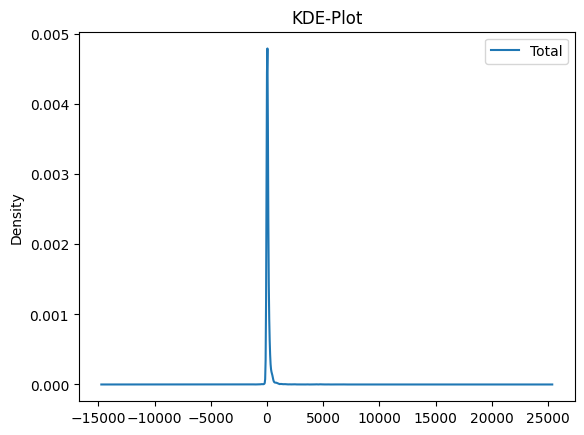

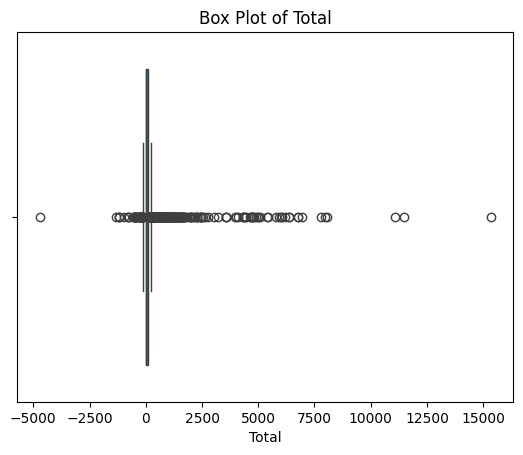

In [40]:
ds['Total'].plot(kind='kde')
plt.title("KDE-Plot")
plt.legend()
plt.show()
sns.boxplot(data=ds,x='Total',)
plt.title("Box Plot of Total")
plt.show()

In [30]:
print("The total categories for the column {} is {}".format(ds['Service Area'].name,ds['Service Area'].nunique()))
print("The total categories for the column {} is {}".format(ds['Account Description'].name,ds['Account Description'].nunique()))
print("The total categories for the column {} is {}".format(ds['Creditor'].name,ds['Creditor'].nunique()))

The total categories for the column Service Area is 24
The total categories for the column Account Description is 67
The total categories for the column Creditor is 1936


In [16]:
# Visualization of Total vs Service area
fig = px.histogram(data_frame=ds,x='Service Area',y='Total',text_auto='.3s',
                   title="Sum of total across different service areas.")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

In [44]:
# Visualization of Total vs Service area
fig = px.histogram(data_frame=ds,x='Account Description',y='Total',text_auto='.1s',
                   title="Sum of total across different Accounts.")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

Although, it may seem not quite intuitive to deduce insights from the plot. We can evaluate that the major expense is towards Equipment and Material Purchase. While Fixtures and fittings has -1,138.74 as the total, which indicates a income or credit rather than a debit.

In [12]:
# Quarterly performance by Service Area
ds['quarter_year_str'] = ds['quarter_year'].apply(lambda x: str(x))
service_list = ds['Service Area'].unique()
app = Dash()
app.layout = html.Div([
    html.H1('Quarterly Performance by Service Area',style={'color':'white'}),
    dcc.Dropdown(
        id="dropdown",
        options=service_list,
        value=service_list[0],
        clearable=False,
    ),
    dcc.Graph(id="qtr_year_graph"),
    dcc.Graph(id="qtr_agg_graph")
])

@app.callback(
    Output("qtr_year_graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(service_area):
    fig = px.histogram(ds[ds['Service Area']==service_area], x="quarter_year_str", y="Total")
    return fig

@app.callback(
    Output("qtr_agg_graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart_agg(service_area):
    fig = px.histogram(ds[ds['Service Area']==service_area], x="quarter", y="Total")
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
    return fig

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

In [54]:
# Quarterly performance by Service Area
ds['quarter_year_str'] = ds['quarter_year'].apply(lambda x: str(x))
service_list = ds['Service Area'].unique()
app = Dash()
app.layout = html.Div([
    html.H1('Quarterly Performance by Service Area (SUM)',style={'color':'white'}),
    dcc.Dropdown(
        id="dropdown",
        options=service_list,
        value=service_list[0],
        clearable=False,
    ),
    dcc.Graph(id="qtr_year_graph_sum"),
    dcc.Graph(id="qtr_agg_graph_sum"),
    html.H1('Quarterly Performance by Service Area (AVERAGE)',style={'color':'white'}),
    dcc.Graph(id="qtr_year_graph_avg"),
    dcc.Graph(id="qtr_agg_graph_avg"),
])

# sum plots
@app.callback(
    Output("qtr_year_graph_sum", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(service_area):
    fig = px.histogram(ds[ds['Service Area']==service_area], x="quarter_year_str", y="Total")
    return fig

@app.callback(
    Output("qtr_agg_graph_sum", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart_agg(service_area):
    fig = px.histogram(ds[ds['Service Area']==service_area], x="quarter", y="Total")
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
    return fig
# Average Plots
@app.callback(
    Output("qtr_year_graph_avg", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(service_area):
    fig = px.histogram(ds[ds['Service Area']==service_area], x="quarter_year_str", y="Total",histfunc='avg')
    return fig

@app.callback(
    Output("qtr_agg_graph_avg", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart_agg(service_area):
    fig = px.histogram(ds[ds['Service Area']==service_area], x="quarter", y="Total",histfunc='avg')
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
    return fig

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

In [53]:
# Quarterly performance by Account Description
ds['quarter_year_str'] = ds['quarter_year'].apply(lambda x: str(x))
service_list = ds['Account Description'].unique()
app = Dash()
app.layout = html.Div([
    html.H1('Quarterly Performance by Account Description',style={'color':'white'}),
    dcc.Dropdown(
        id="dropdown",
        options=service_list,
        value=service_list[0],
        clearable=False,
    ),
    dcc.Graph(id="qtr_year_graph"),
    dcc.Graph(id="qtr_agg_graph")
])

@app.callback(
    Output("qtr_year_graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(service_area):
    fig = px.histogram(ds[ds['Account Description']==service_area], x="quarter_year_str", y="Total")
    return fig

@app.callback(
    Output("qtr_agg_graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart_agg(service_area):
    fig = px.histogram(ds[ds['Account Description']==service_area], x="quarter", y="Total")
    fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
    return fig

app.run_server(debug=True, use_reloader=False)  # Turn off reloader if inside Jupyter

In [64]:
# Sum 
data = ds.drop(columns=['Journal Date','quarter_year']).groupby(['Service Area','quarter_year_str']).sum()[['Total']].reset_index()
fig = px.bar(data, x = 'quarter_year_str', y = 'Total',color = 'Service Area',title="Total-Sum")
fig.show()
# Avg
data = ds[['Service Area','quarter_year_str','Total']].groupby(['Service Area','quarter_year_str']).mean()[['Total']].reset_index()
fig = px.scatter(data, x = 'quarter_year_str', y = 'Total',color = 'Service Area', title="Total-Average")
fig.show()
# Count
data = ds[['Service Area','quarter_year_str','Total']].groupby(['Service Area','quarter_year_str']).count()[['Total']].reset_index()
fig = px.scatter(data, x = 'quarter_year_str', y = 'Total',color = 'Service Area',title="Total-Count")
fig.show()


2. The Auditor would like to get a view if there are any significant changes in spending behavior by
Service Area and by Account. Changes in behavior could be spikes, but could also be permanent
increases in the transaction amounts. Please identify instances of both or show that they do not
exist in the data. 

Monthly trends

In [23]:
px.bar(ts_ds_ym,x=ts_ds_ym.index,y='Total_Avg')

Quarterly 

In [29]:
fig = px.line(ts_ds_q,x=ts_ds_q.index,y='Total_Avg')
fig.show()
fig = px.line(ts_ds_q,x=ts_ds_q.index,y='Total_Count',markers='x')
fig.show()

Quarterly wrt service area

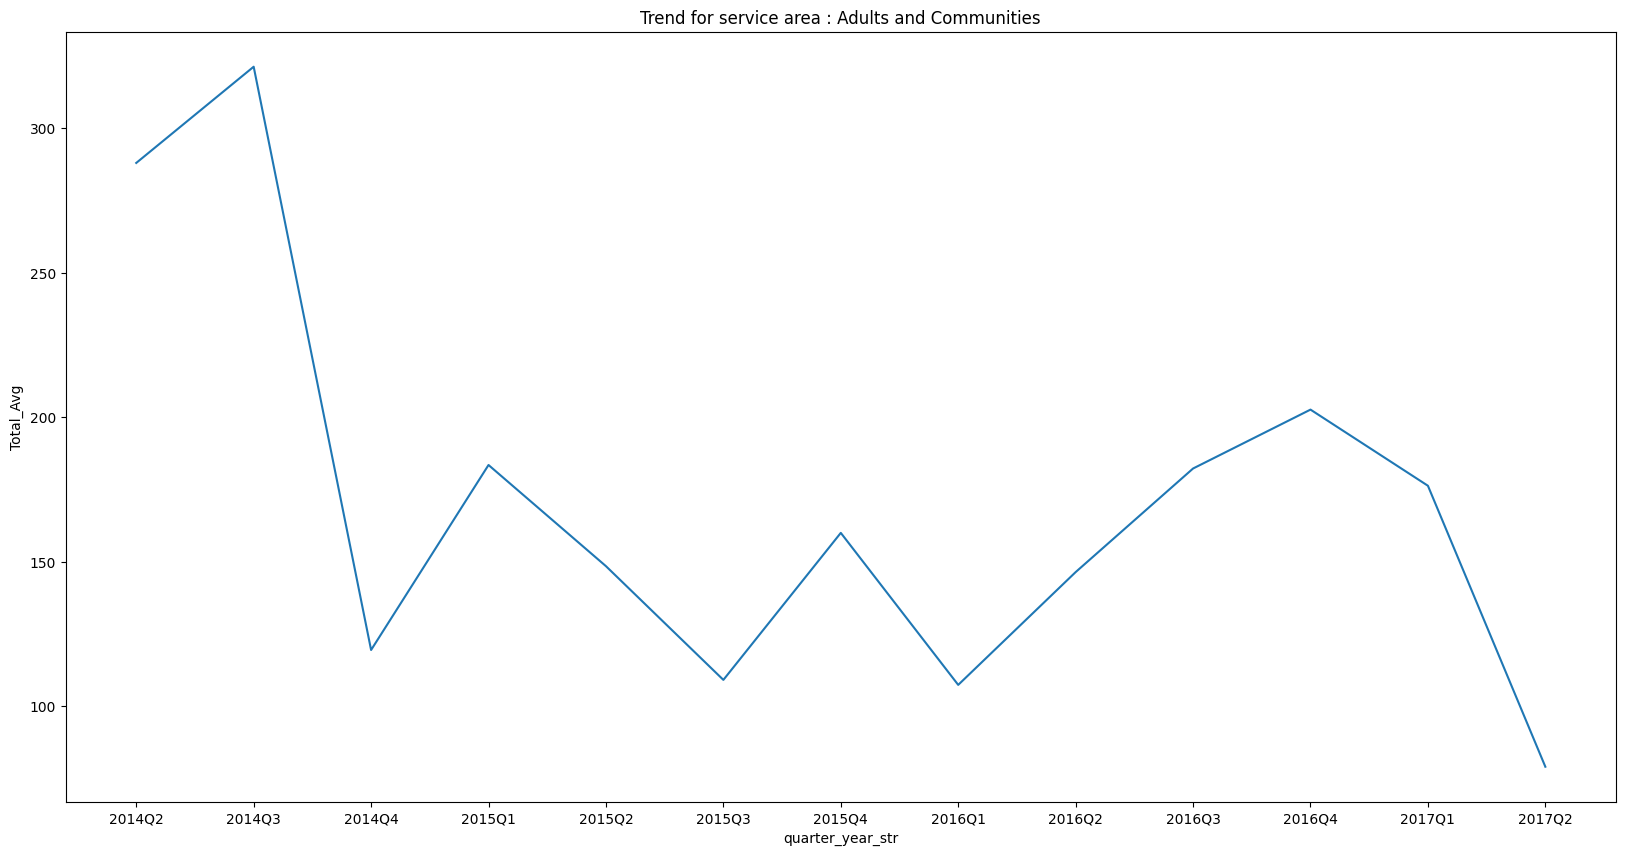

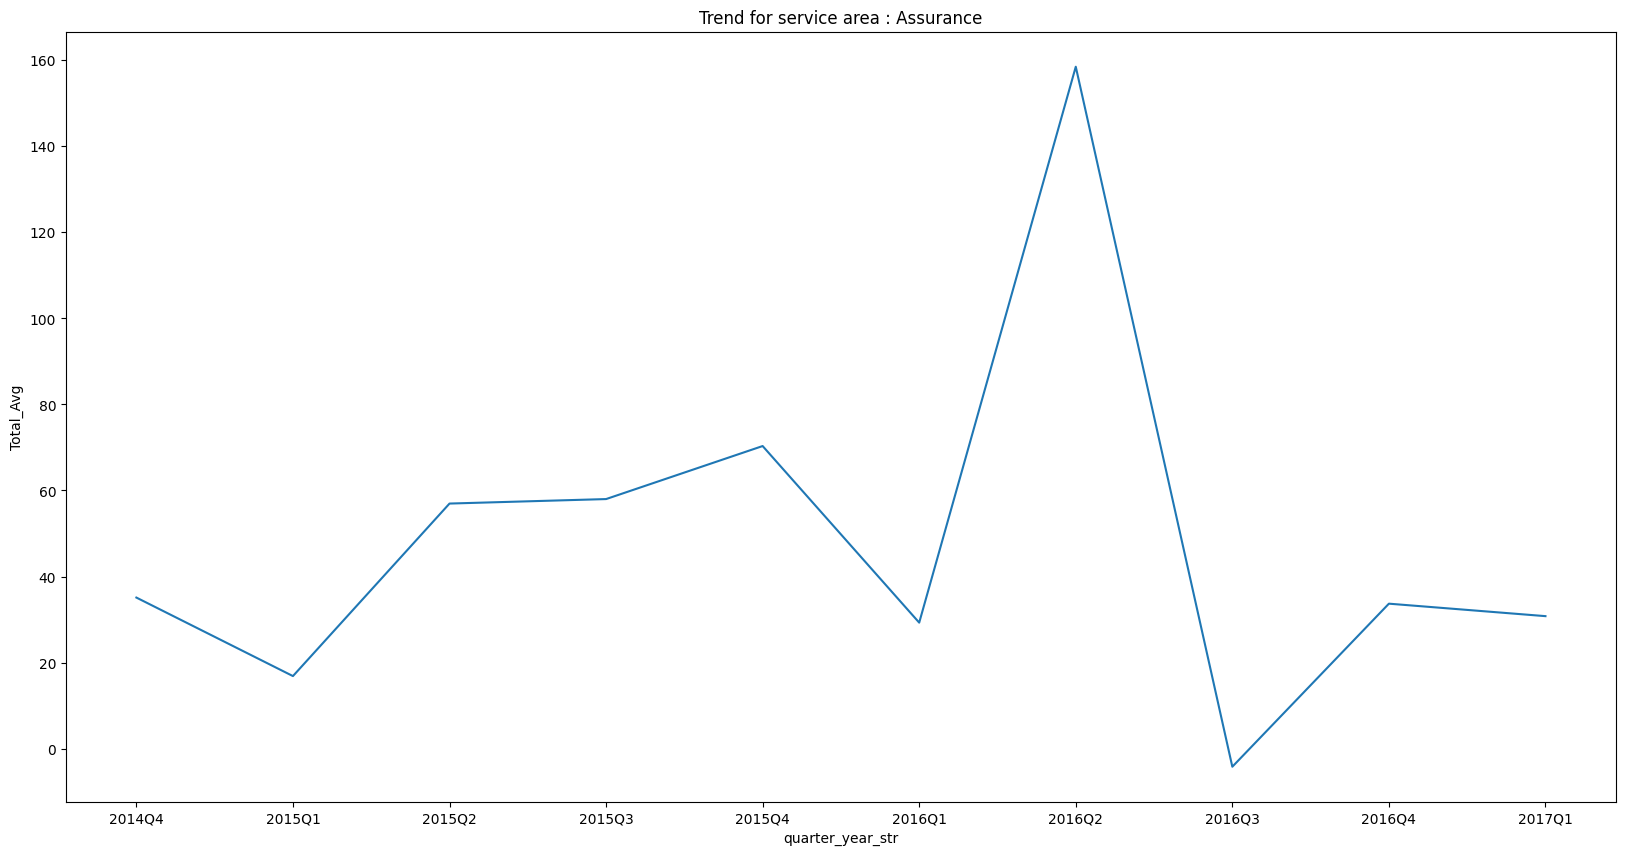

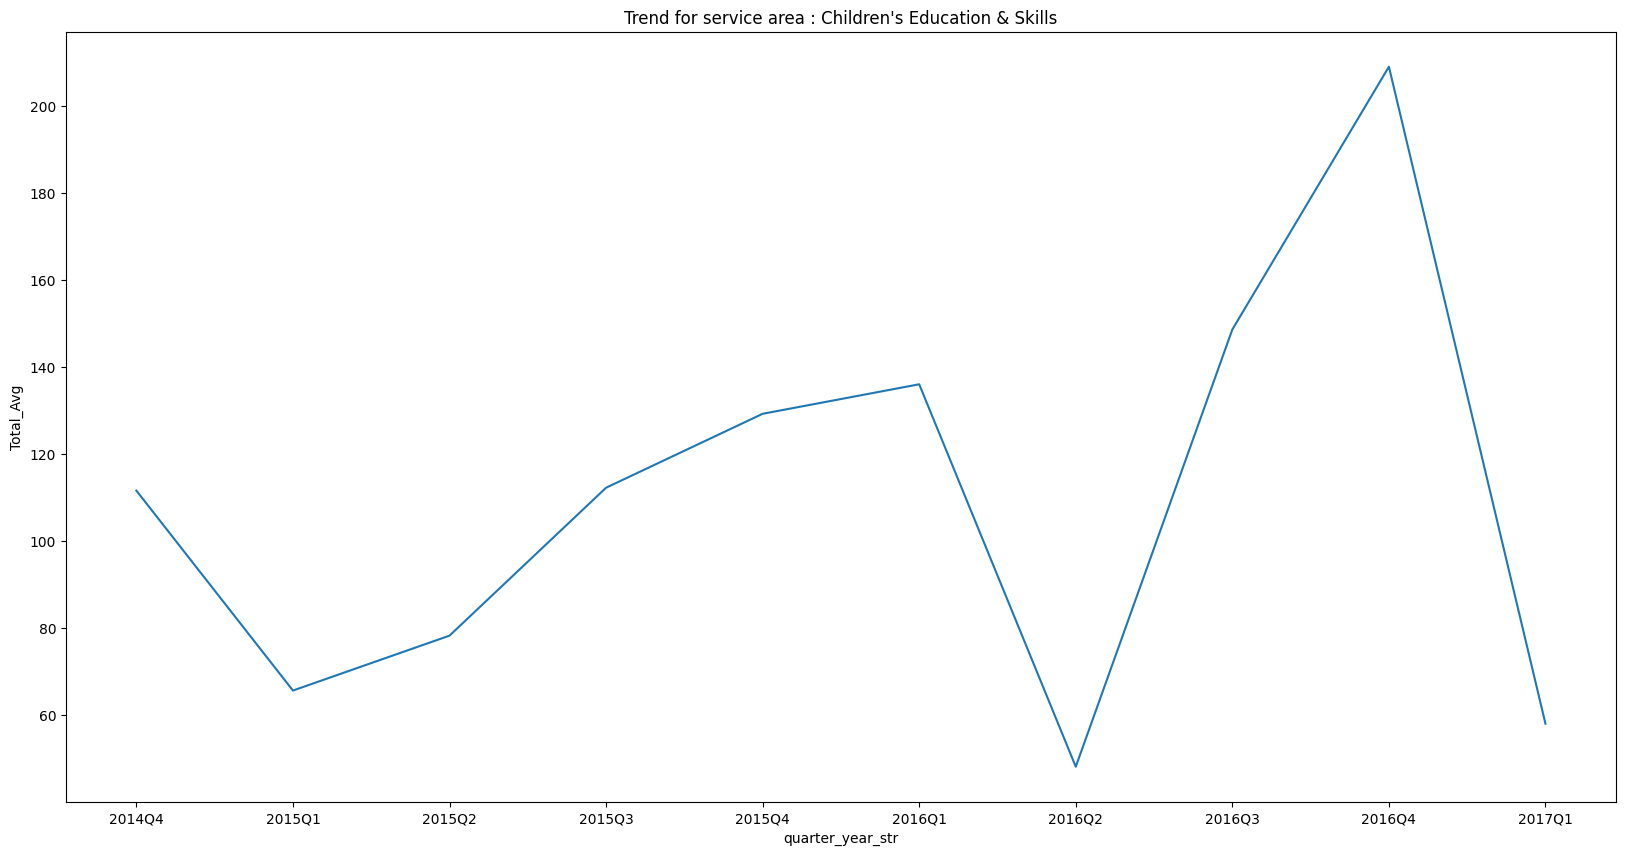

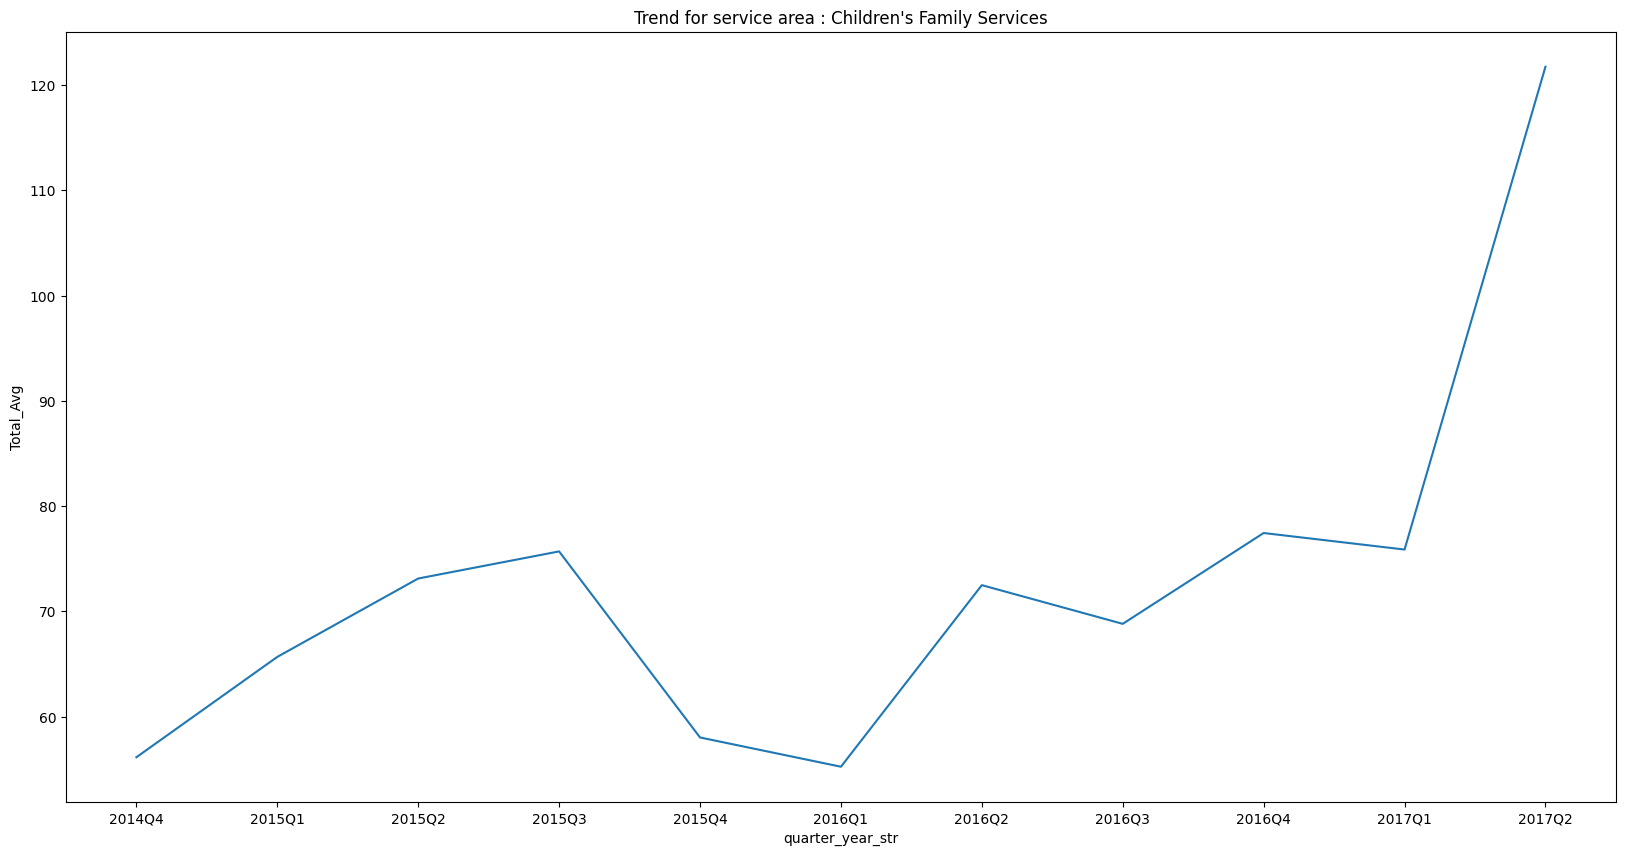

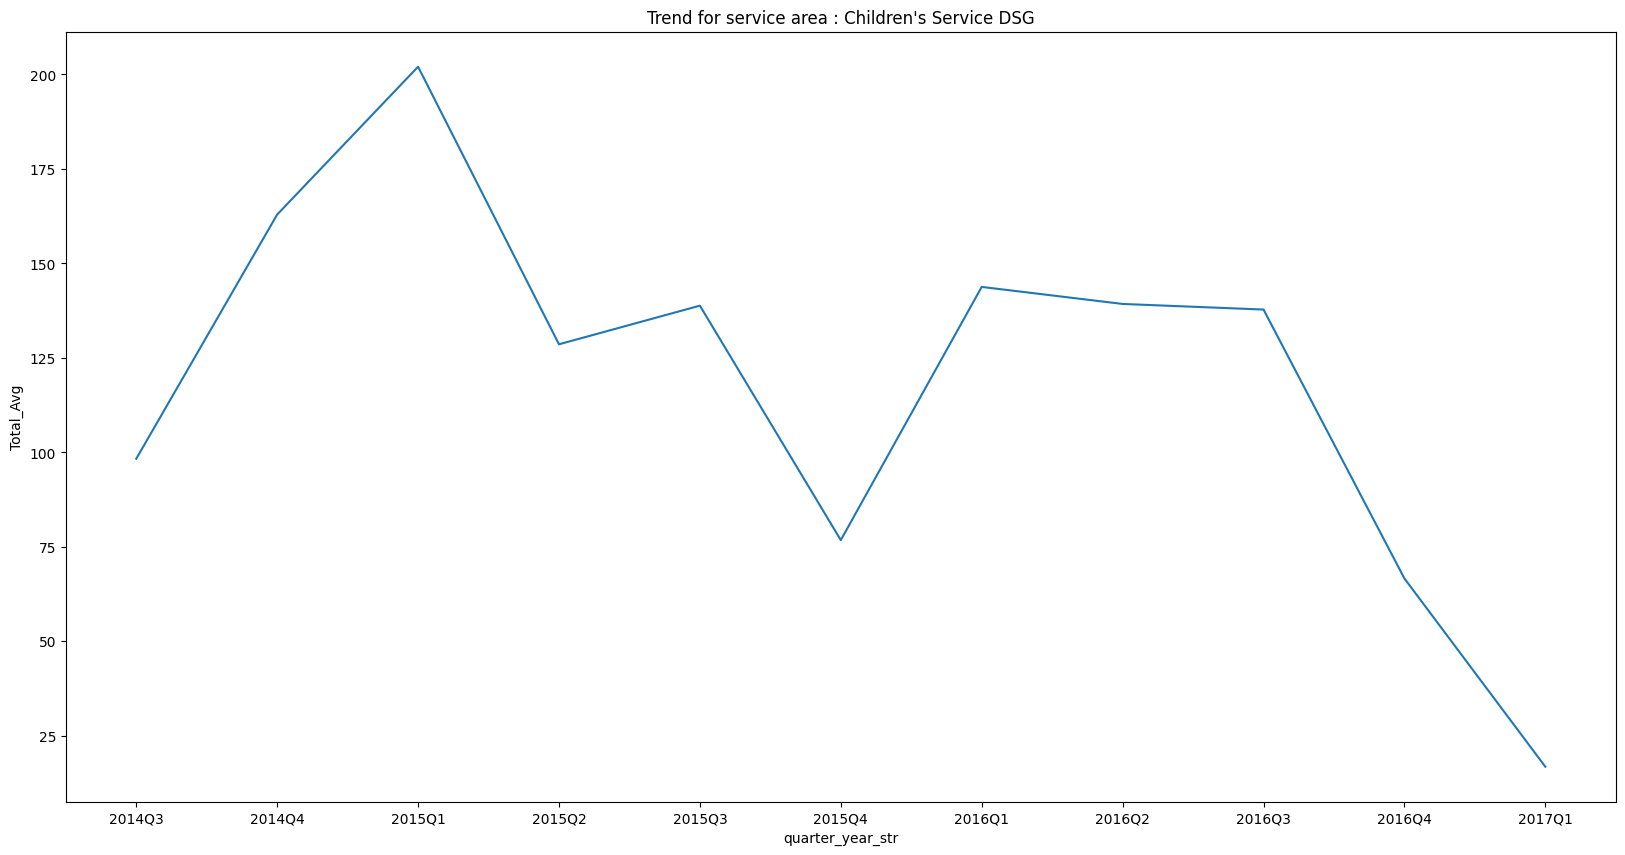

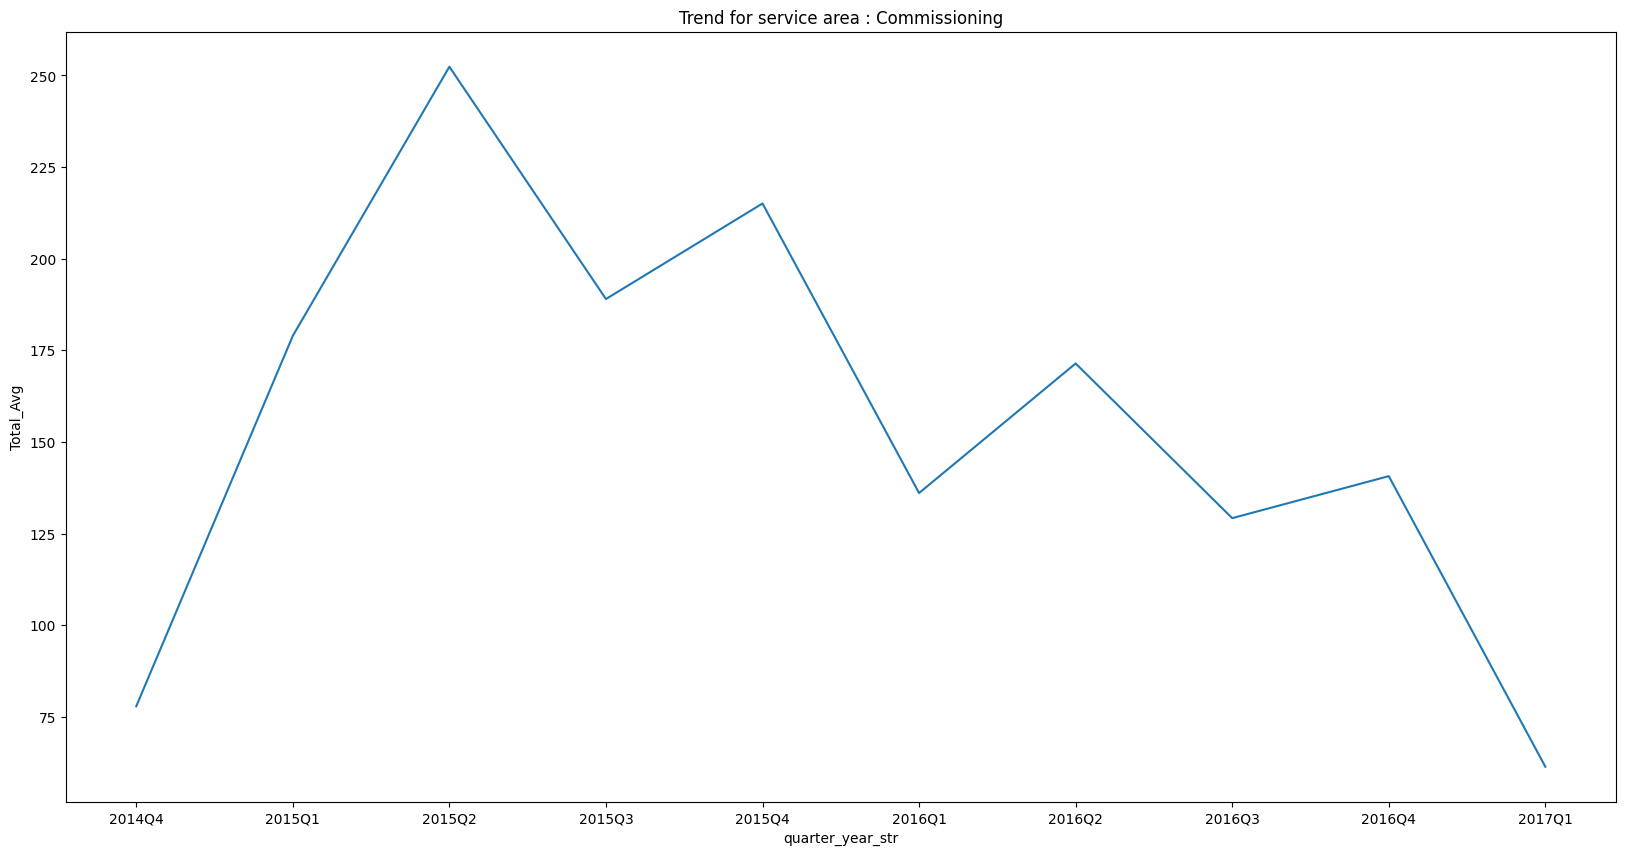

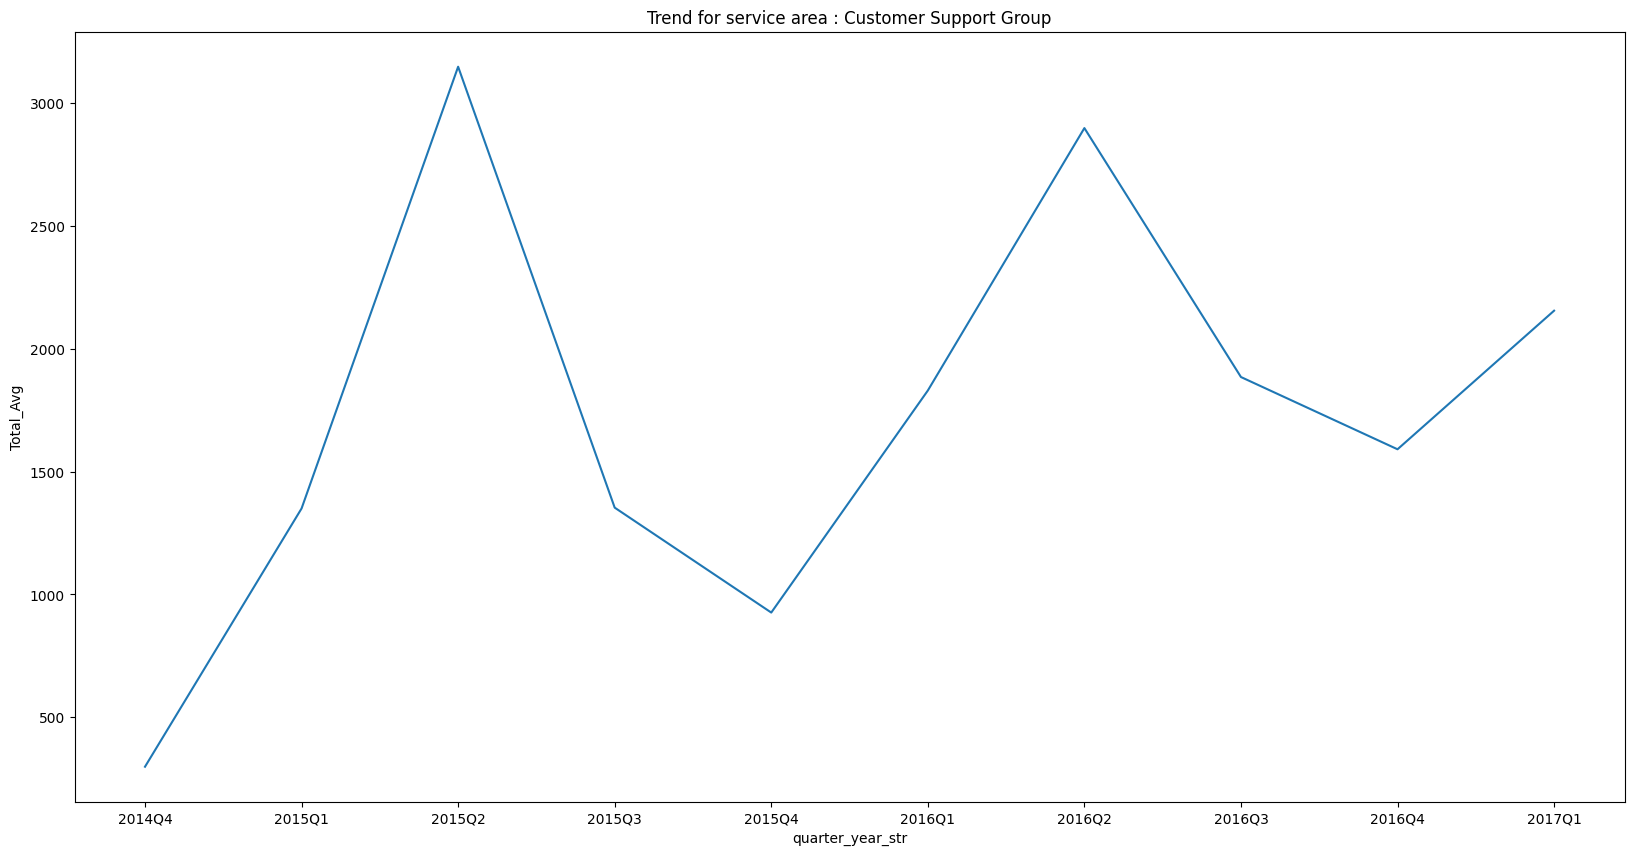

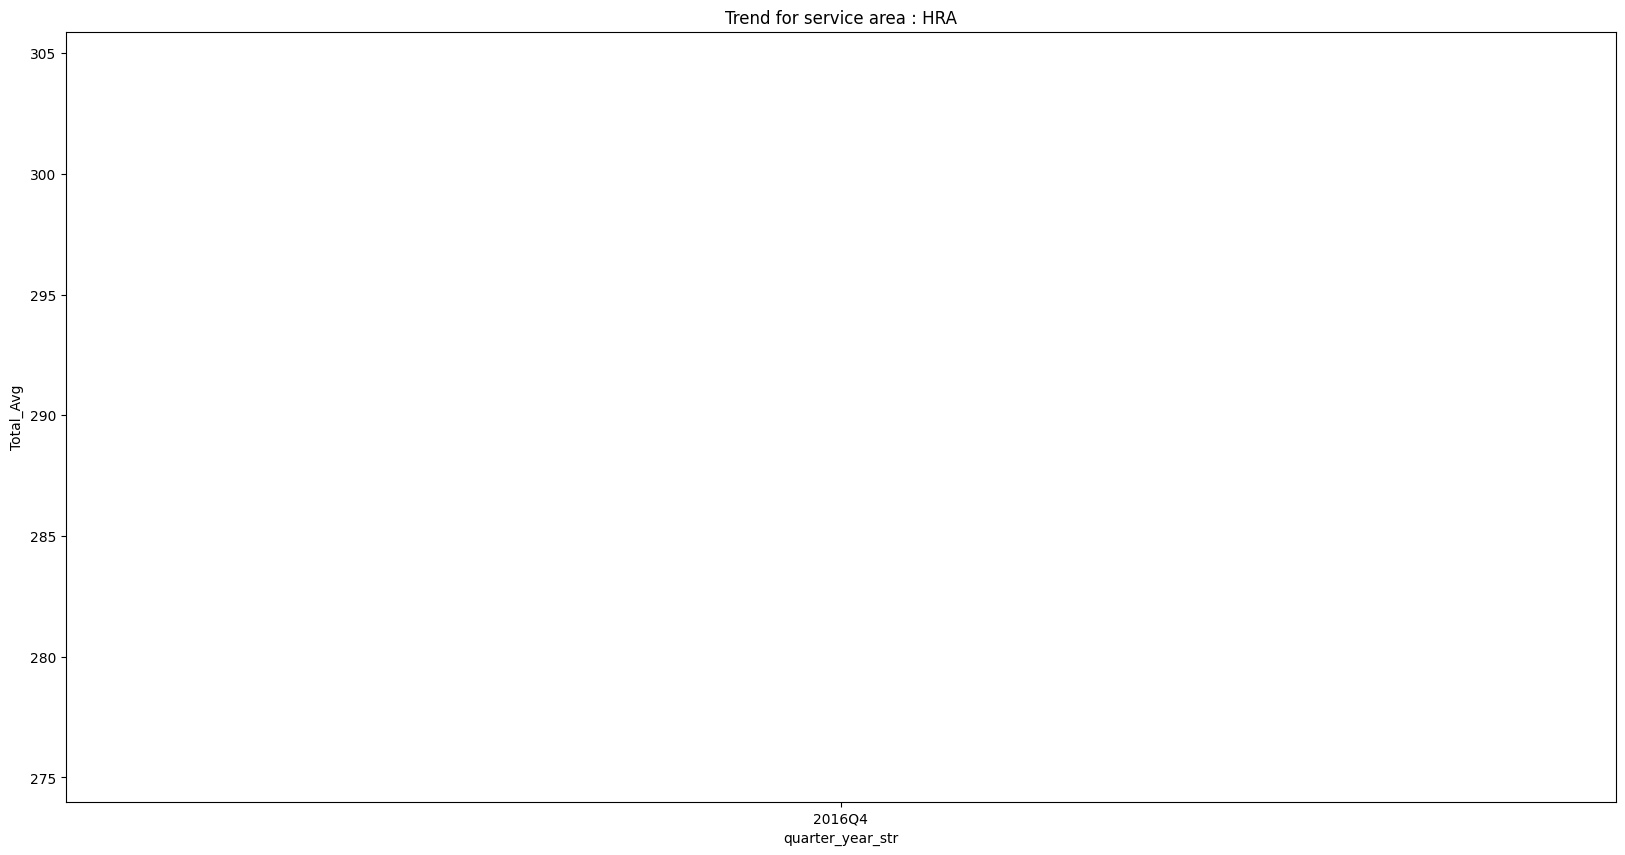

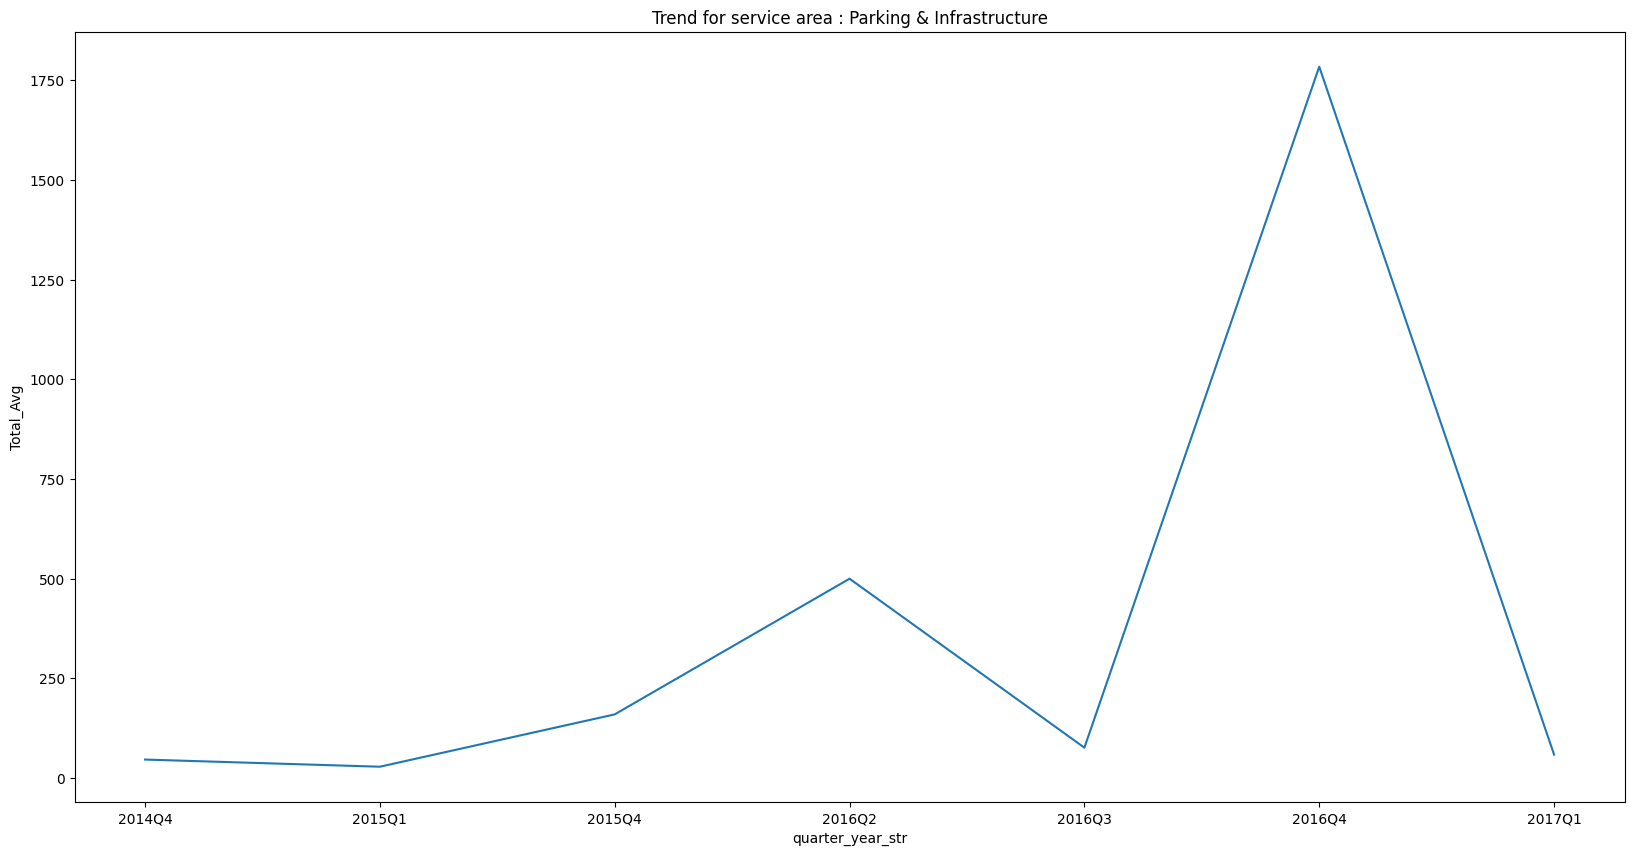

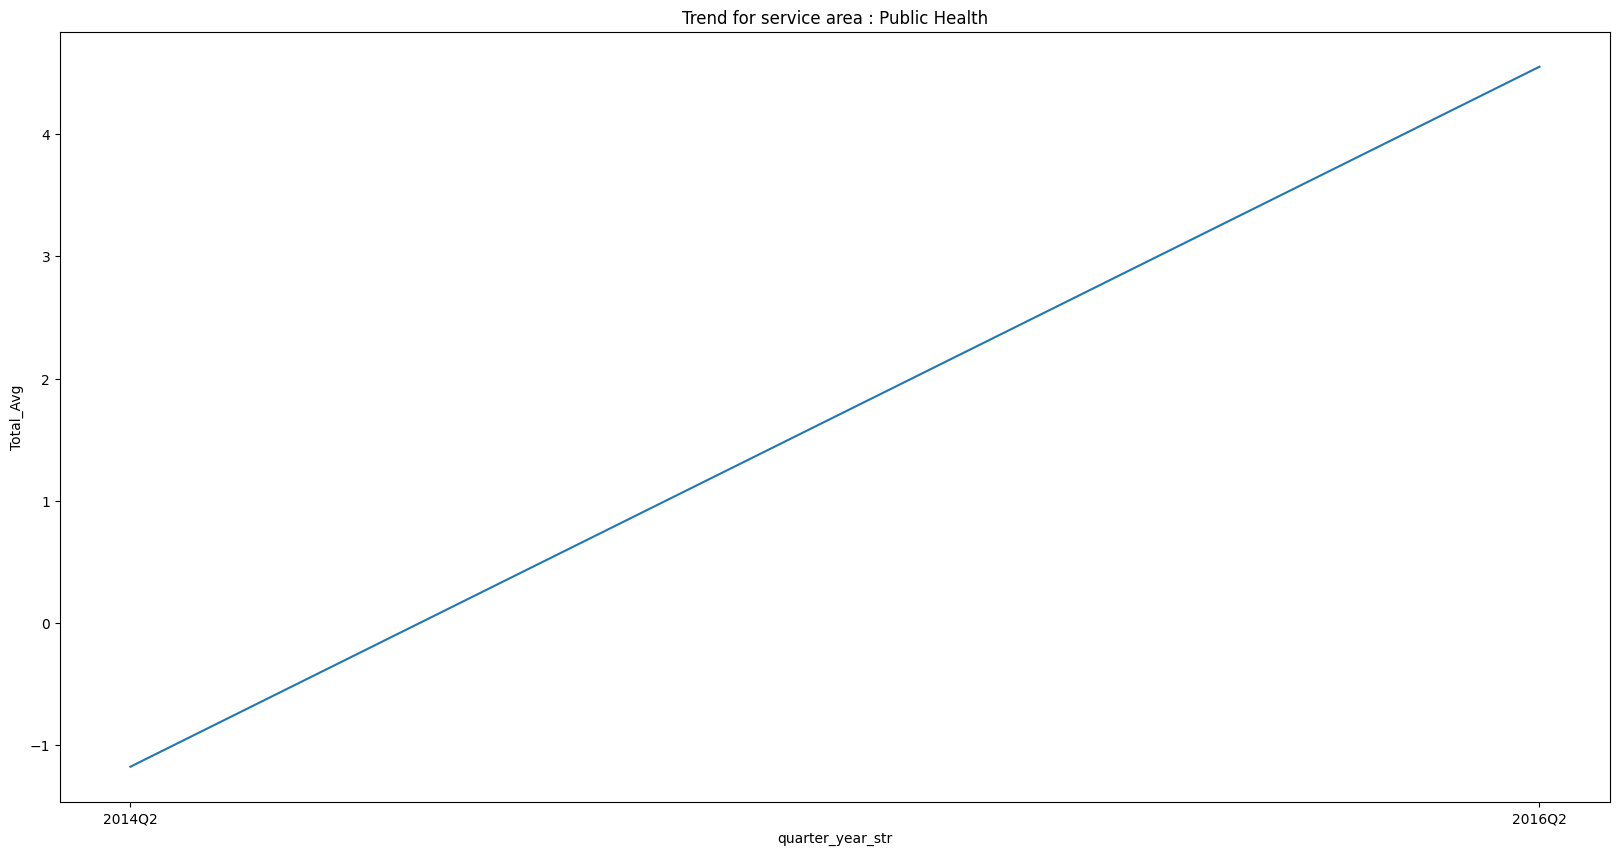

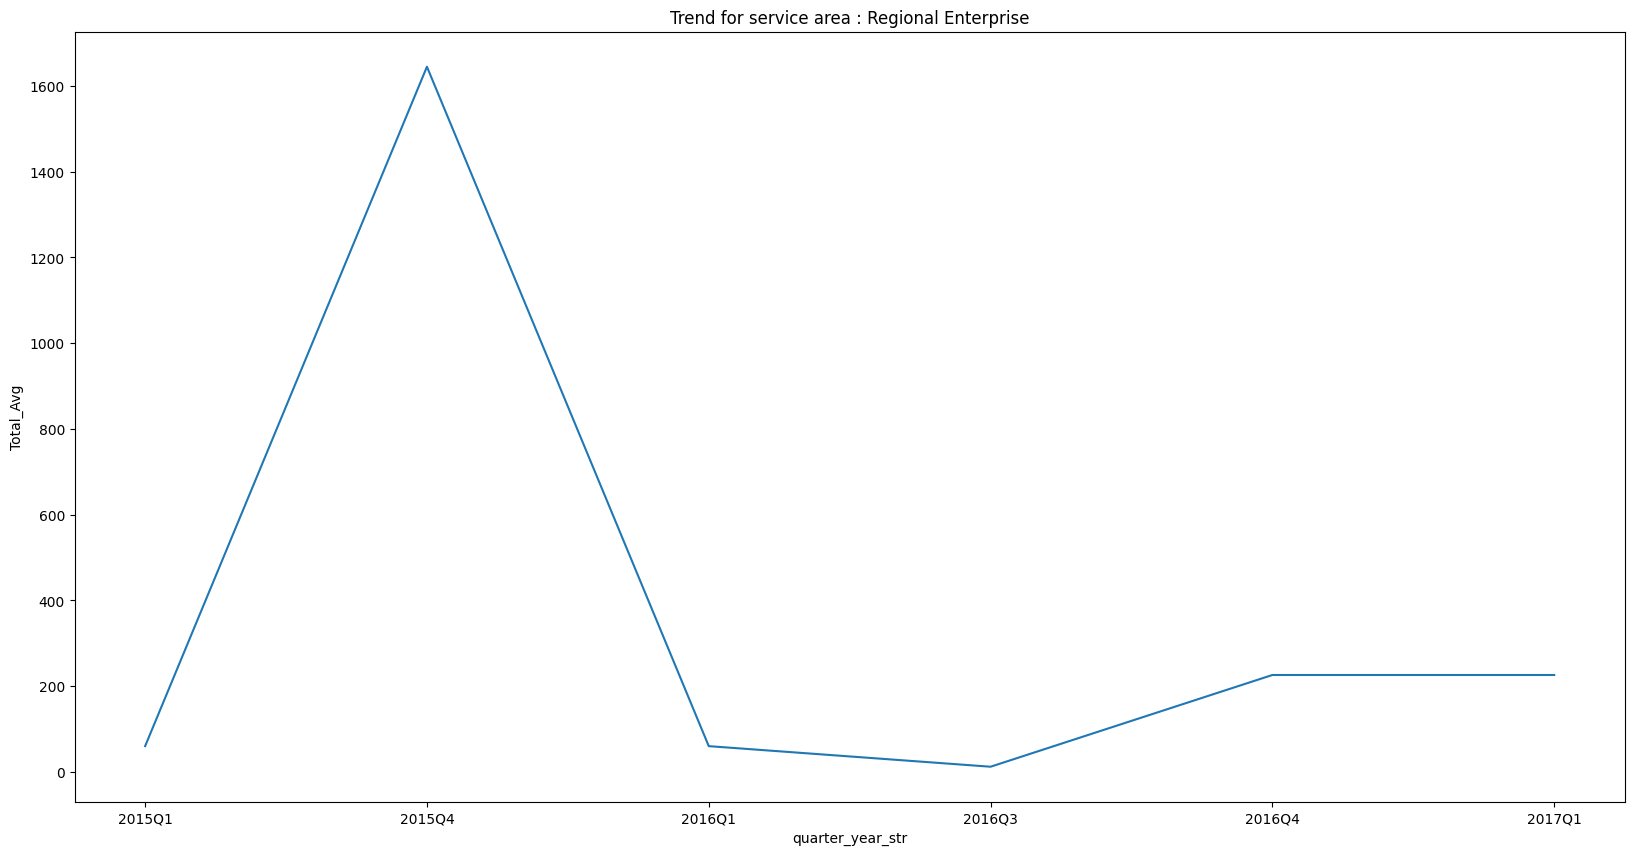

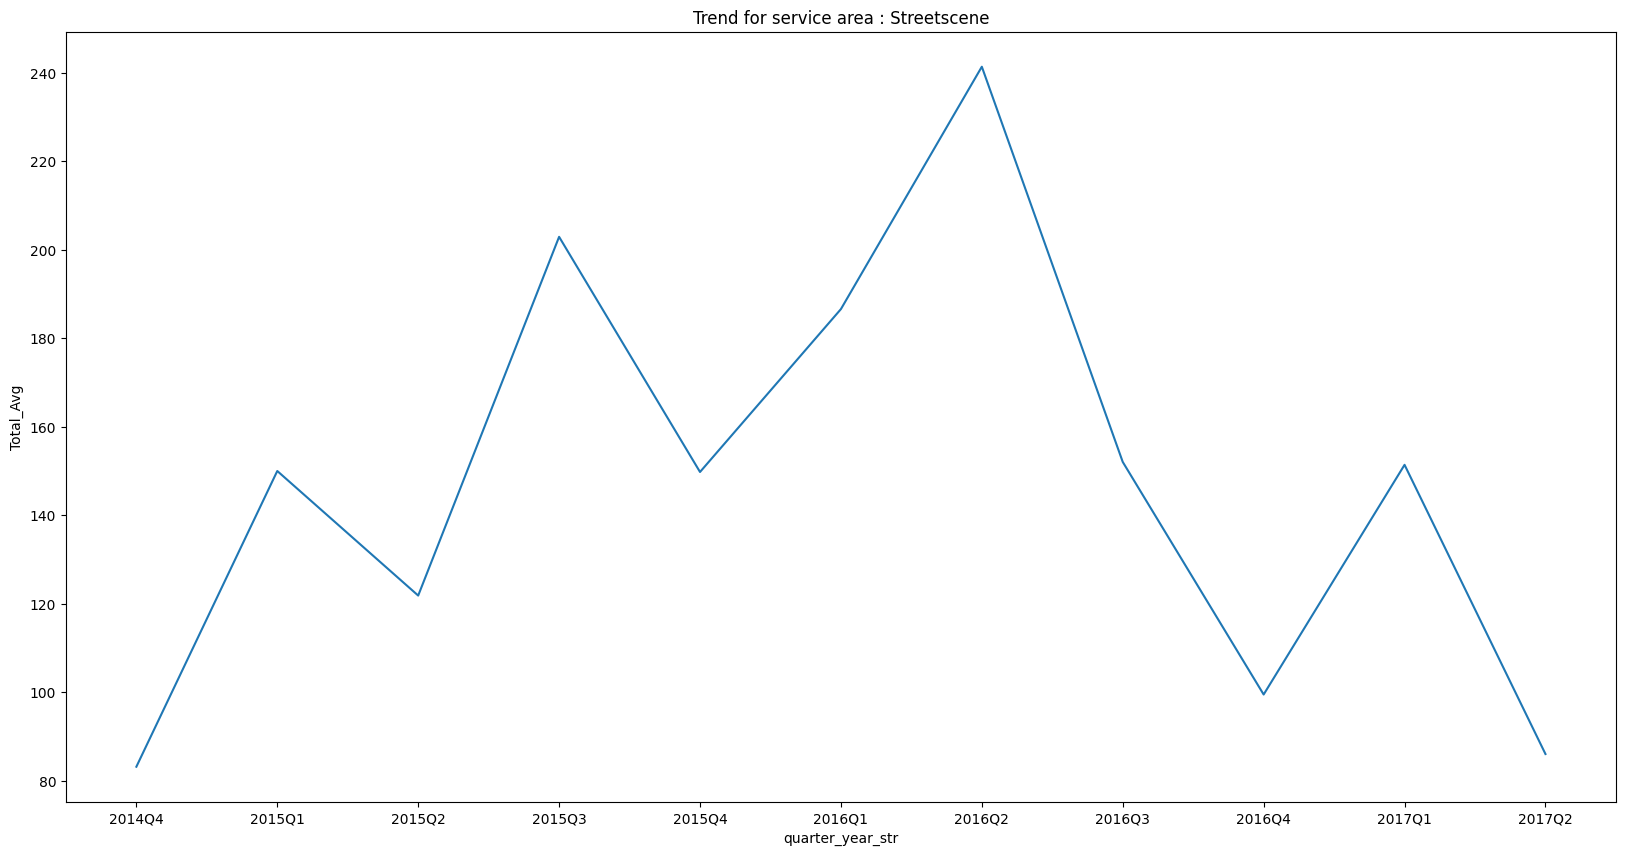

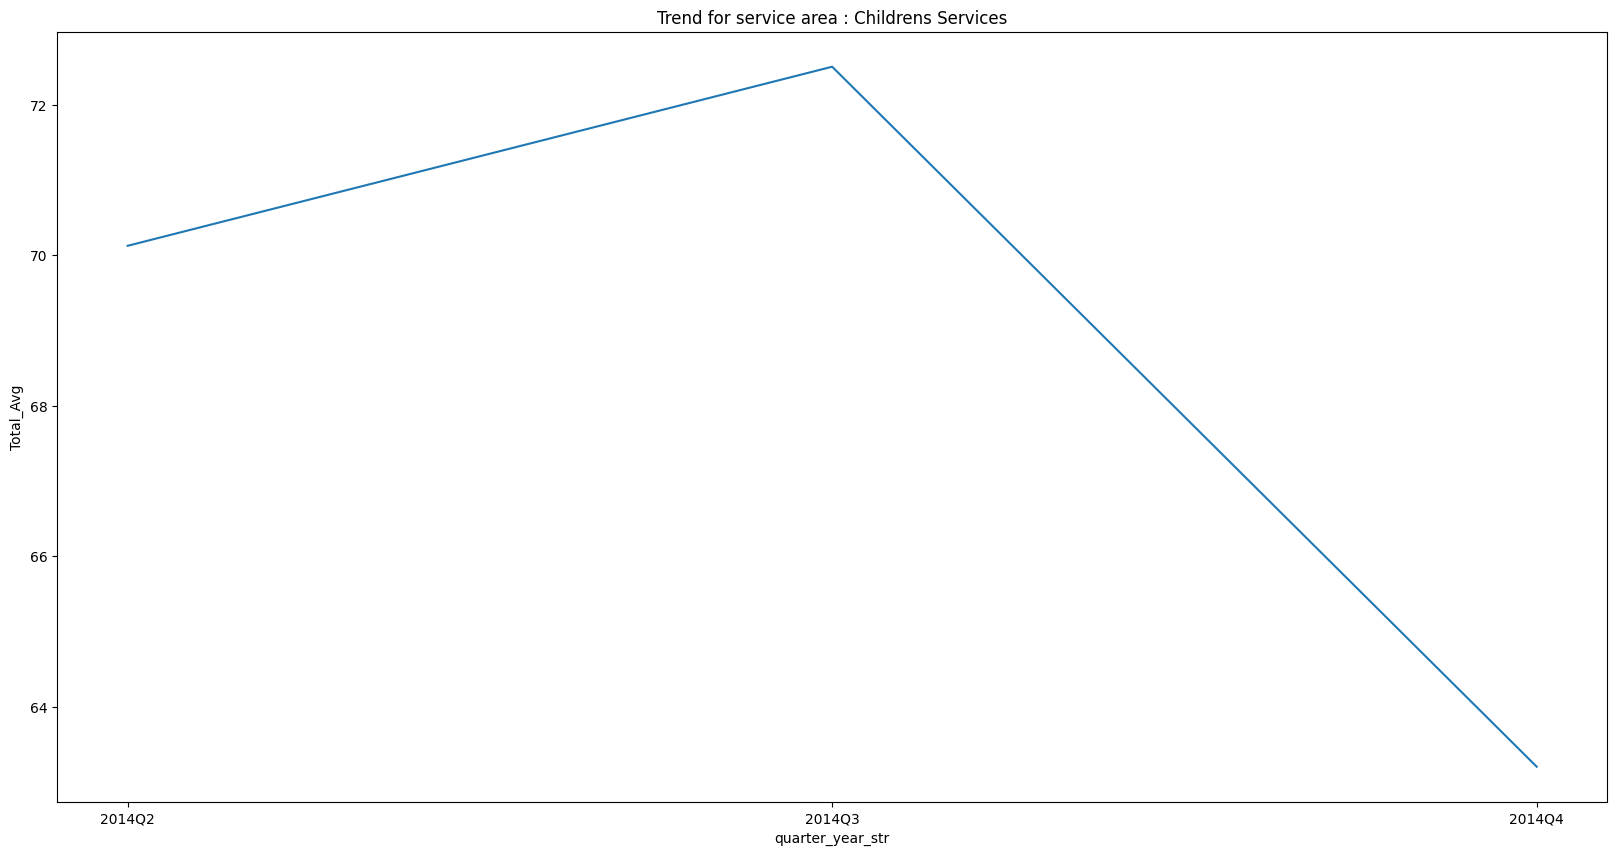

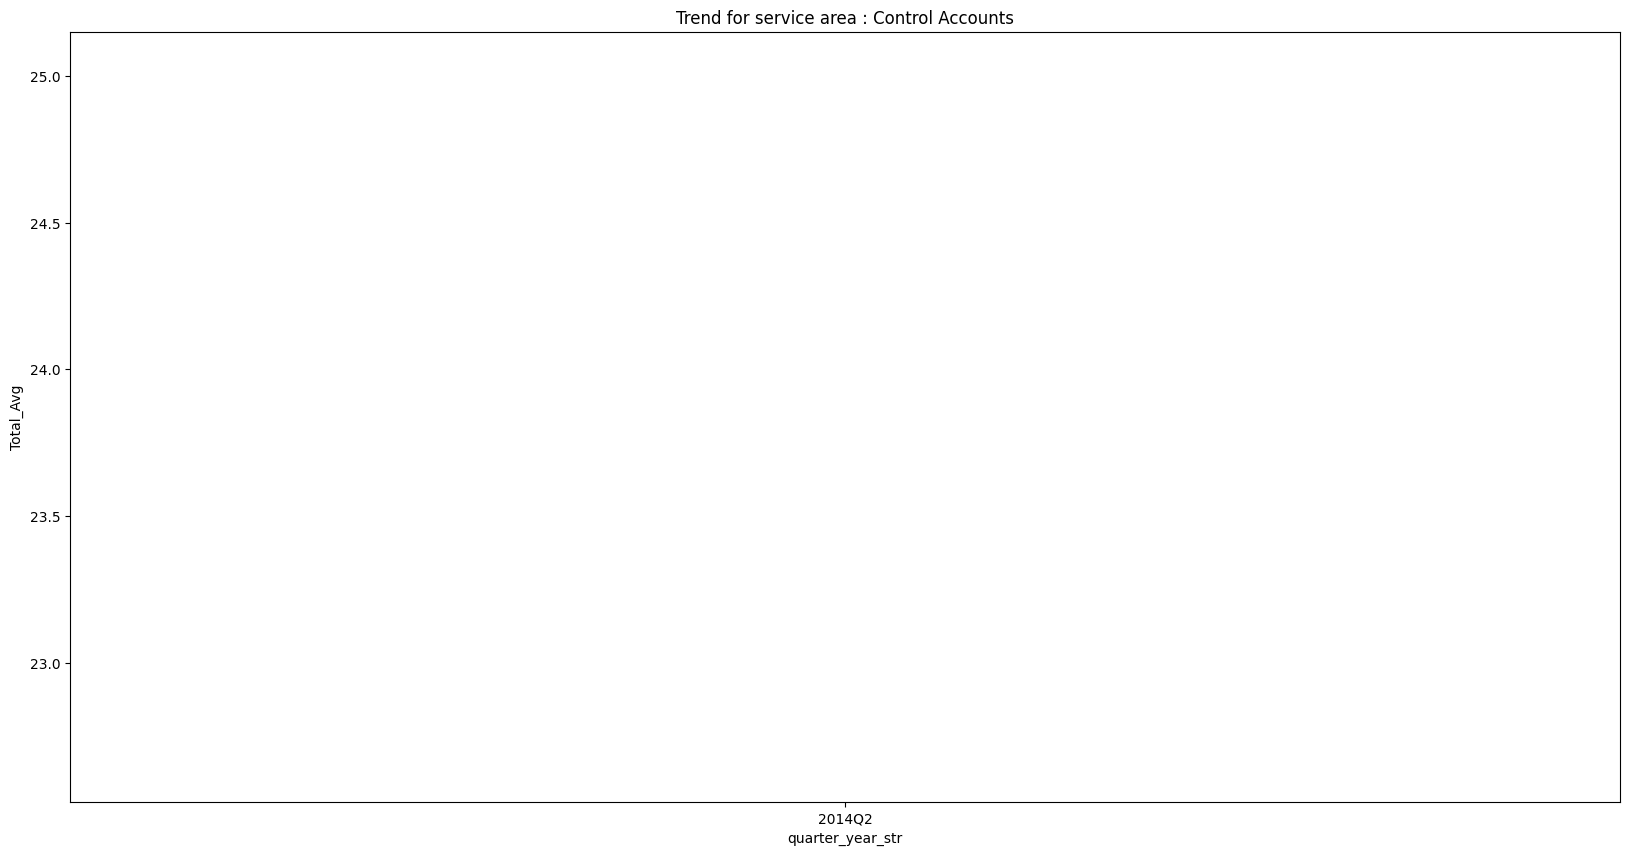

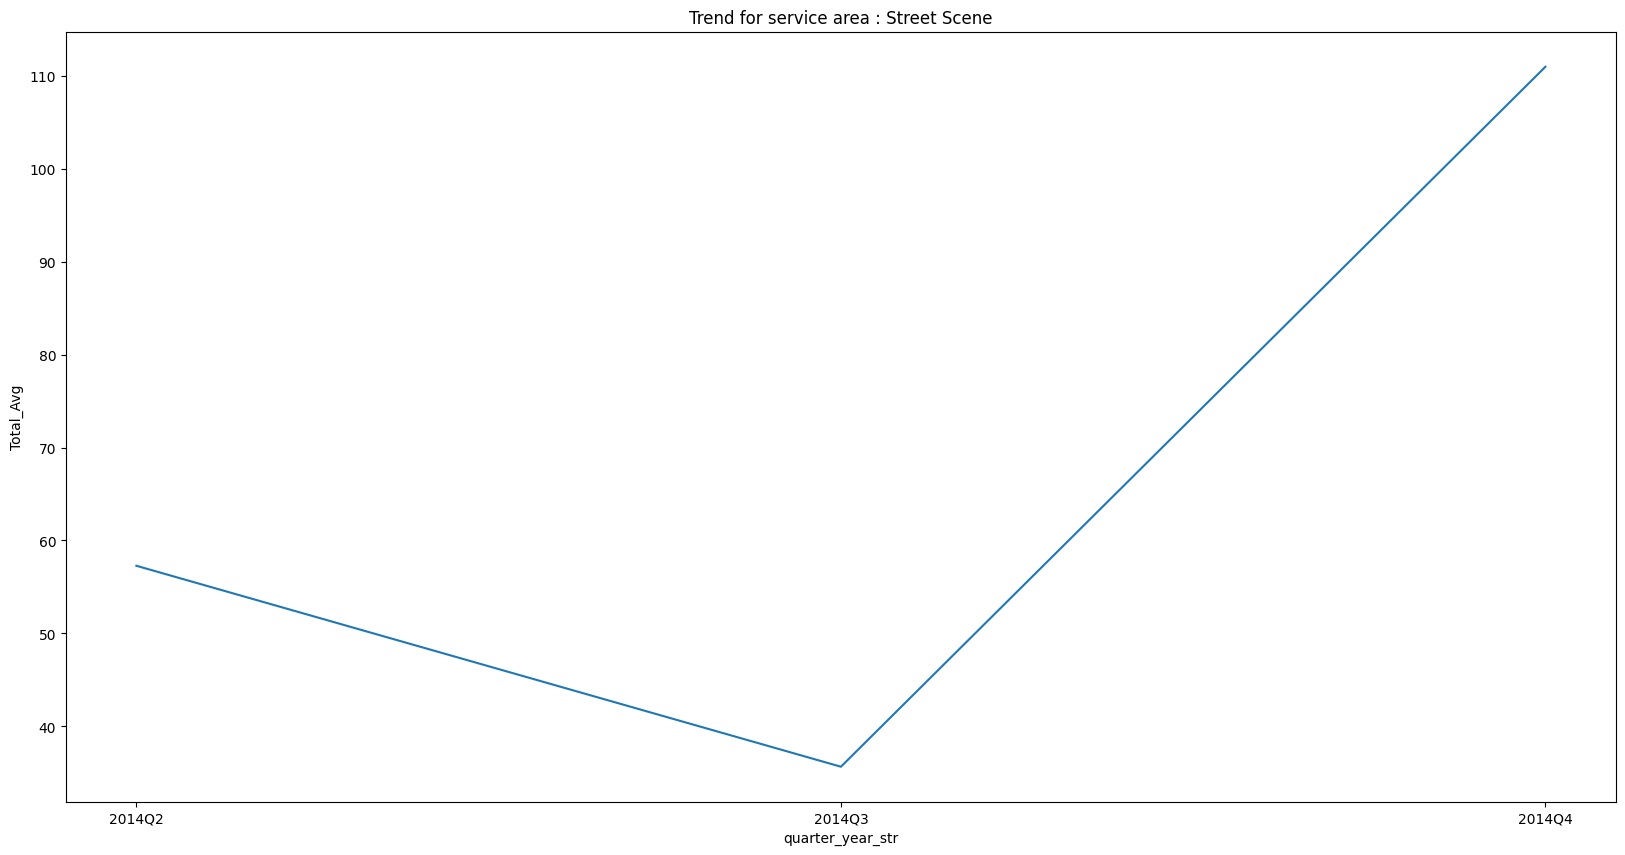

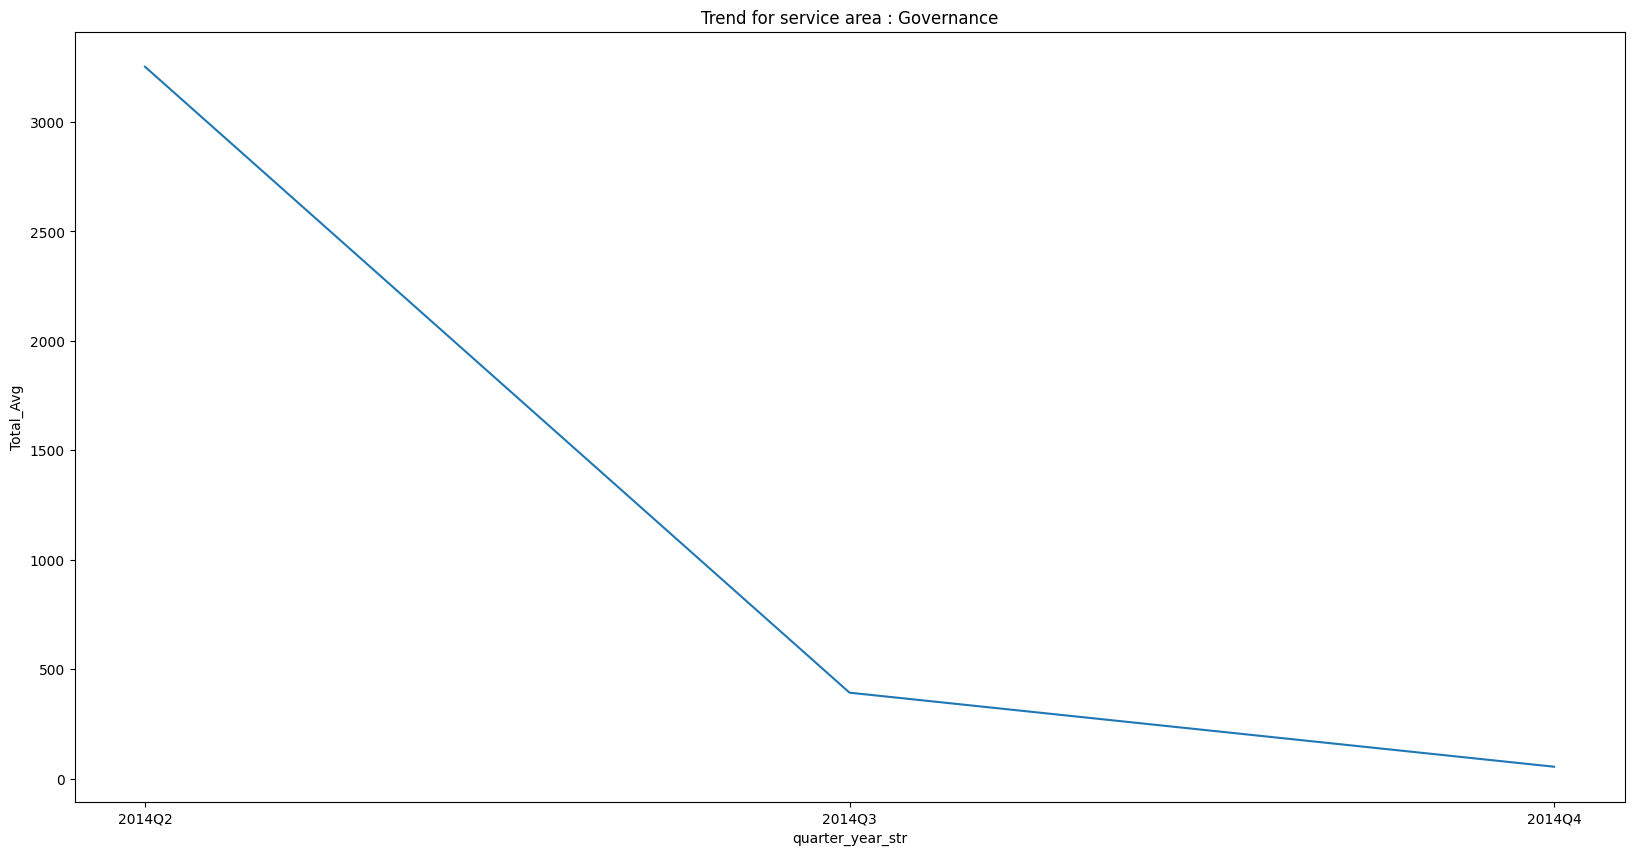

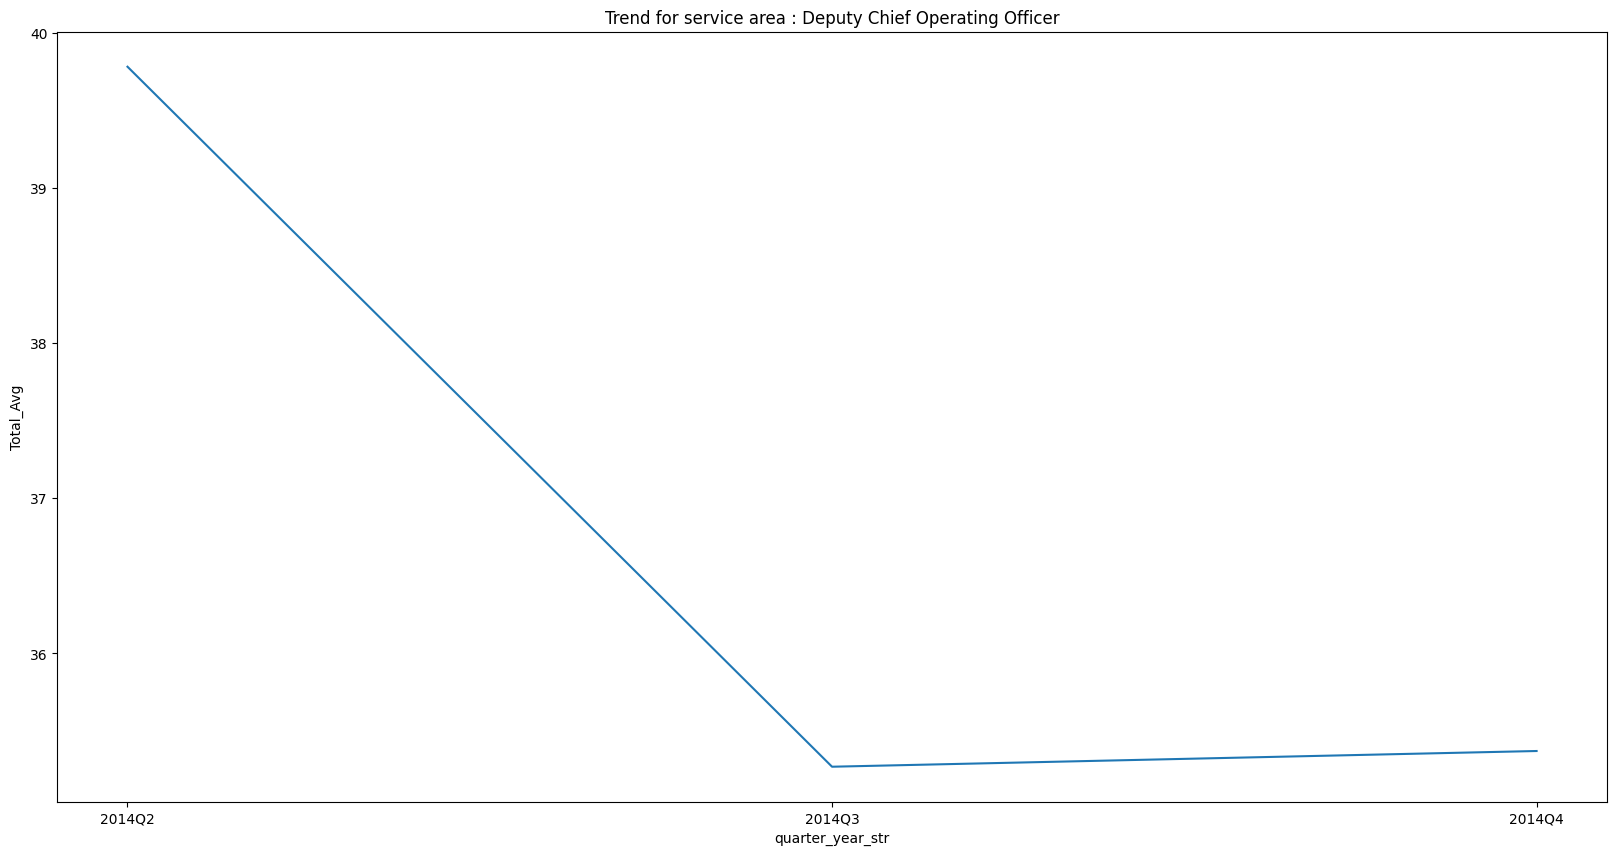

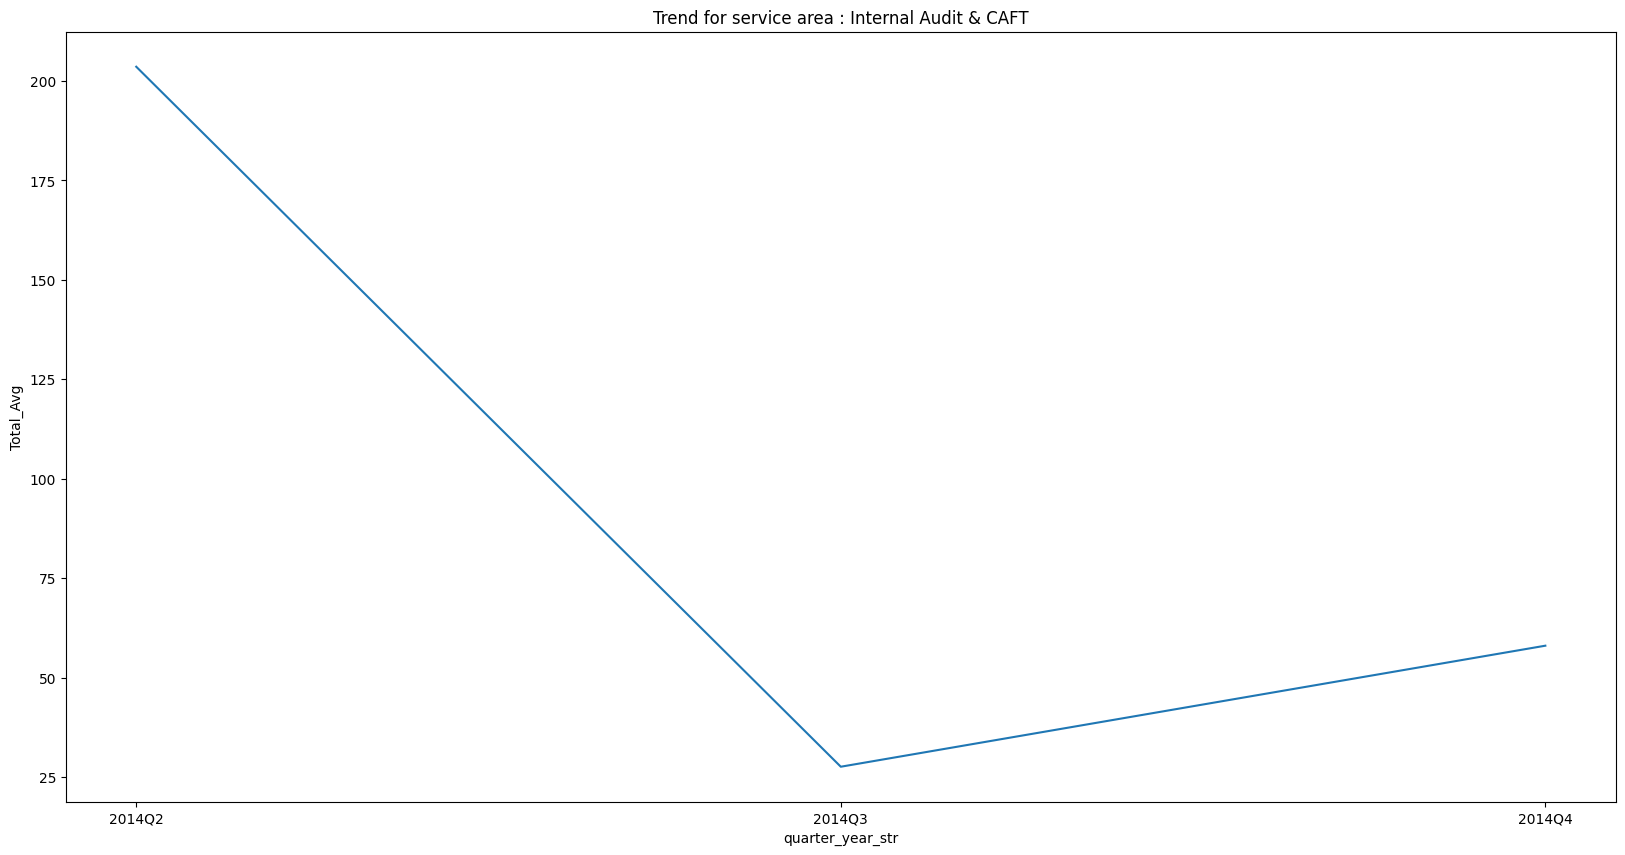

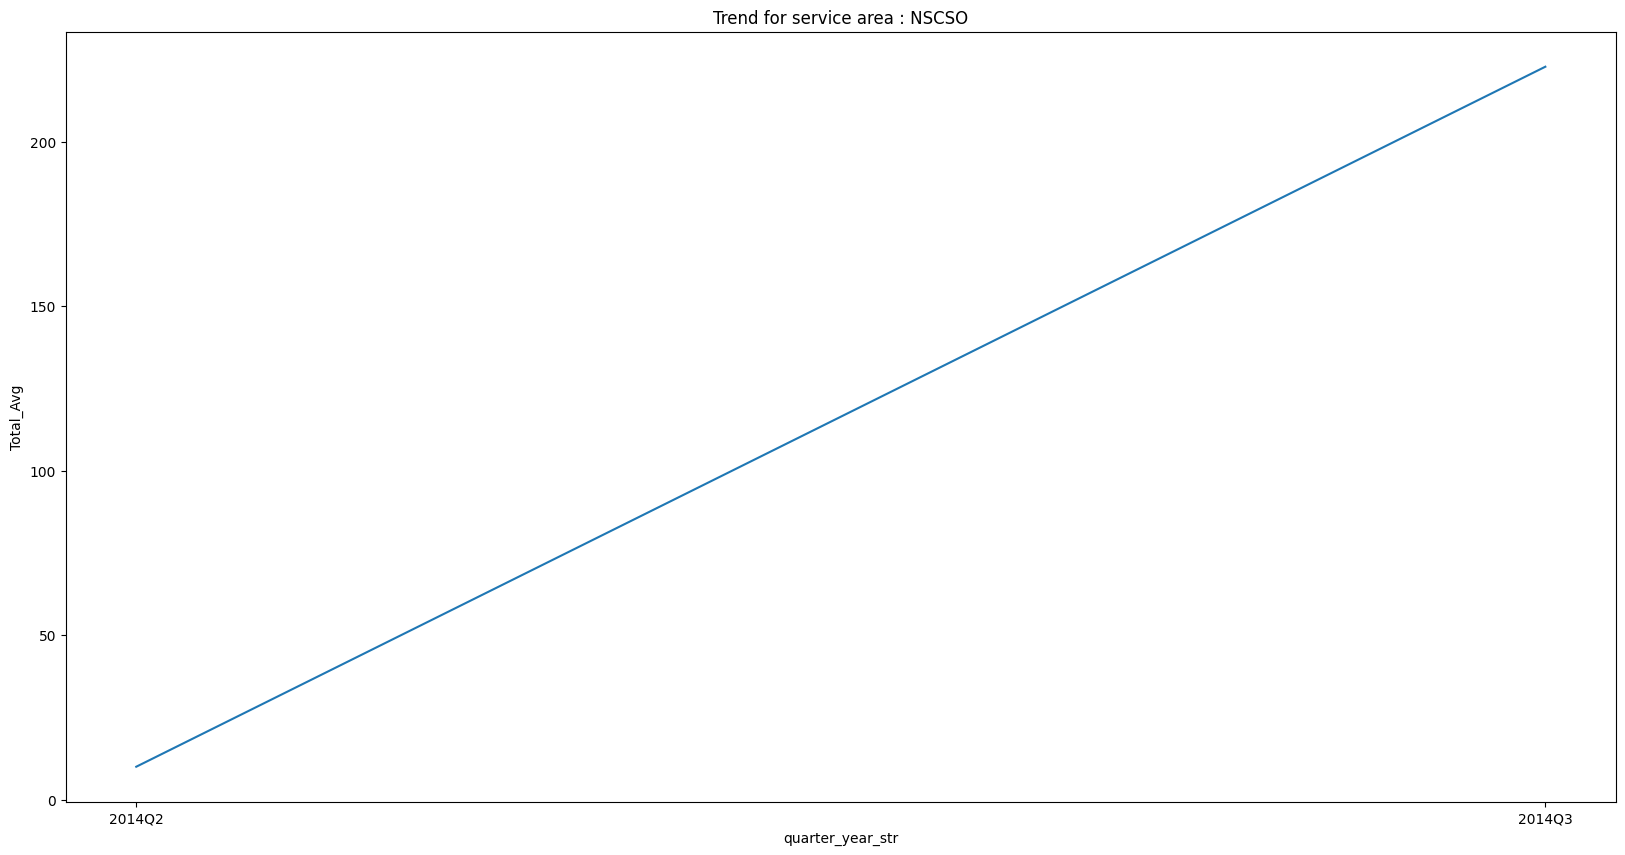

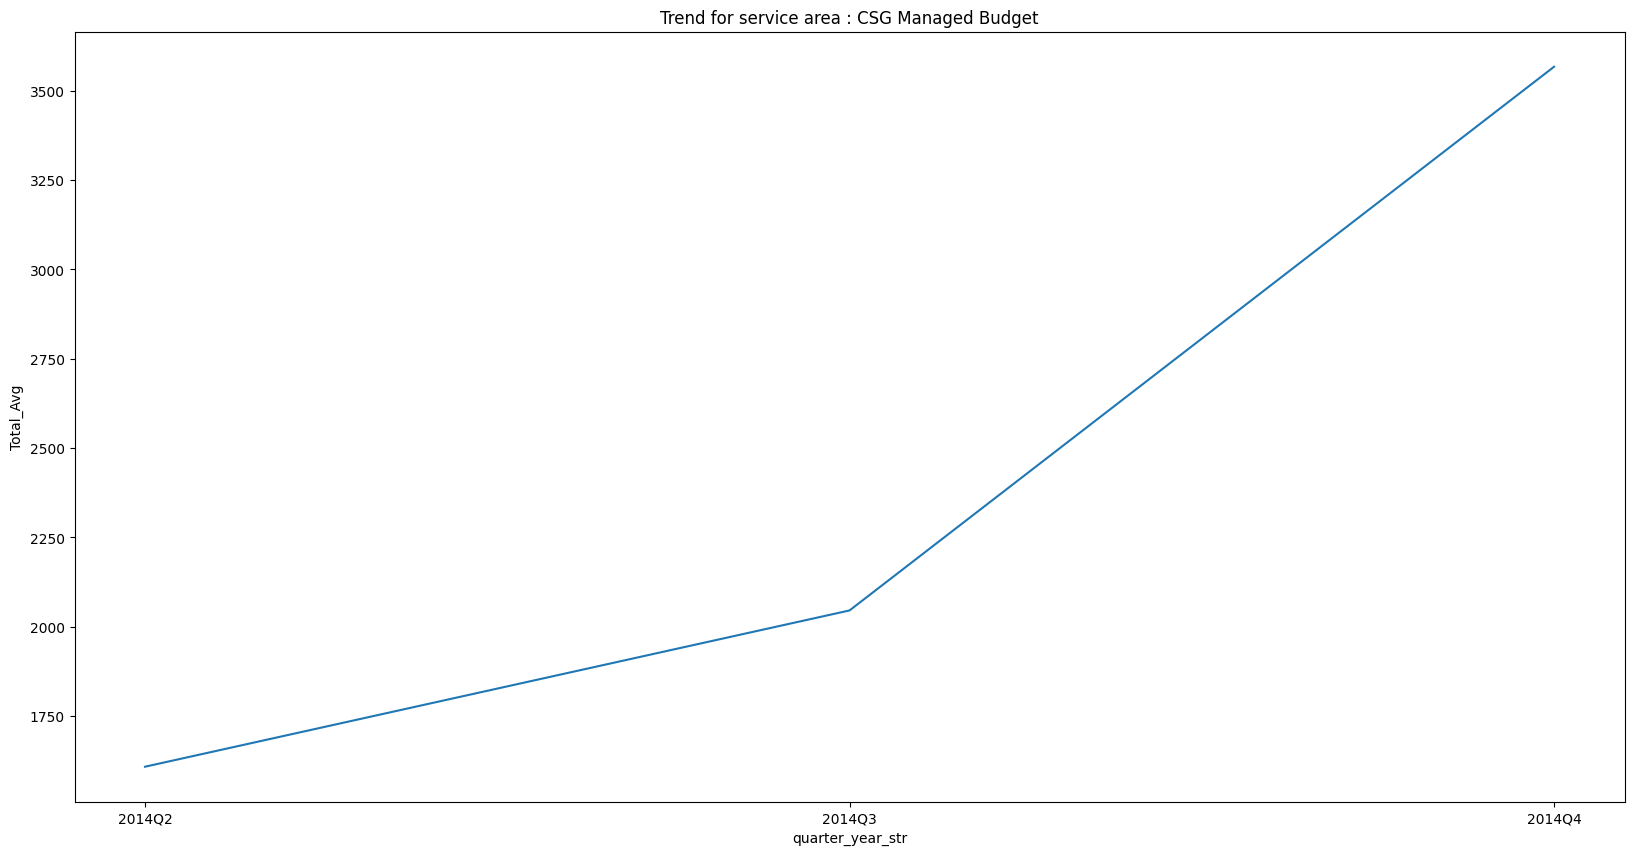

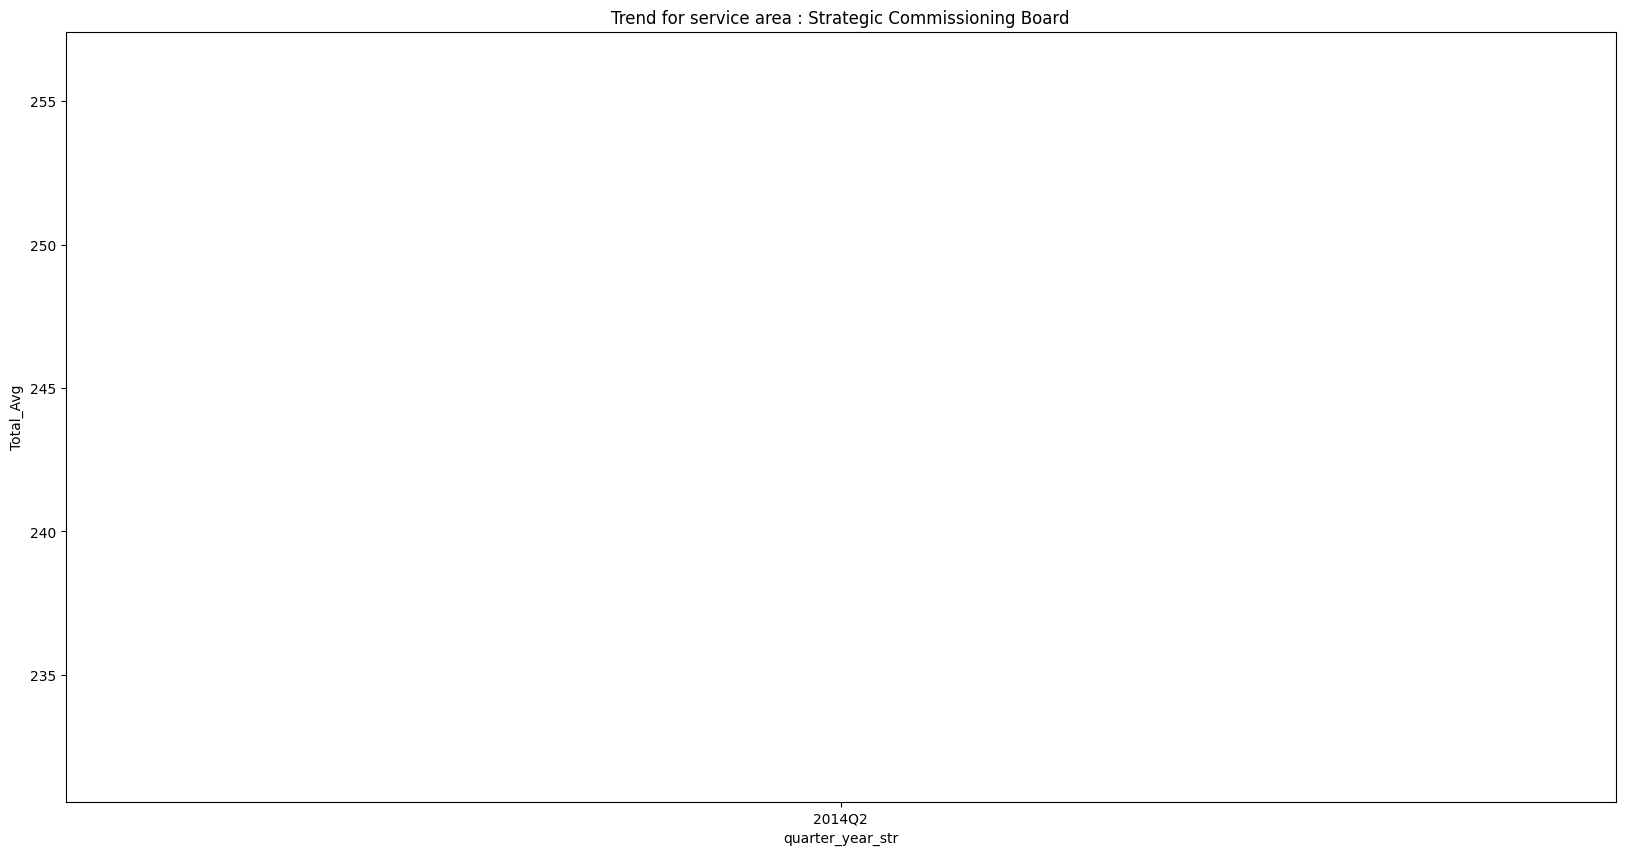

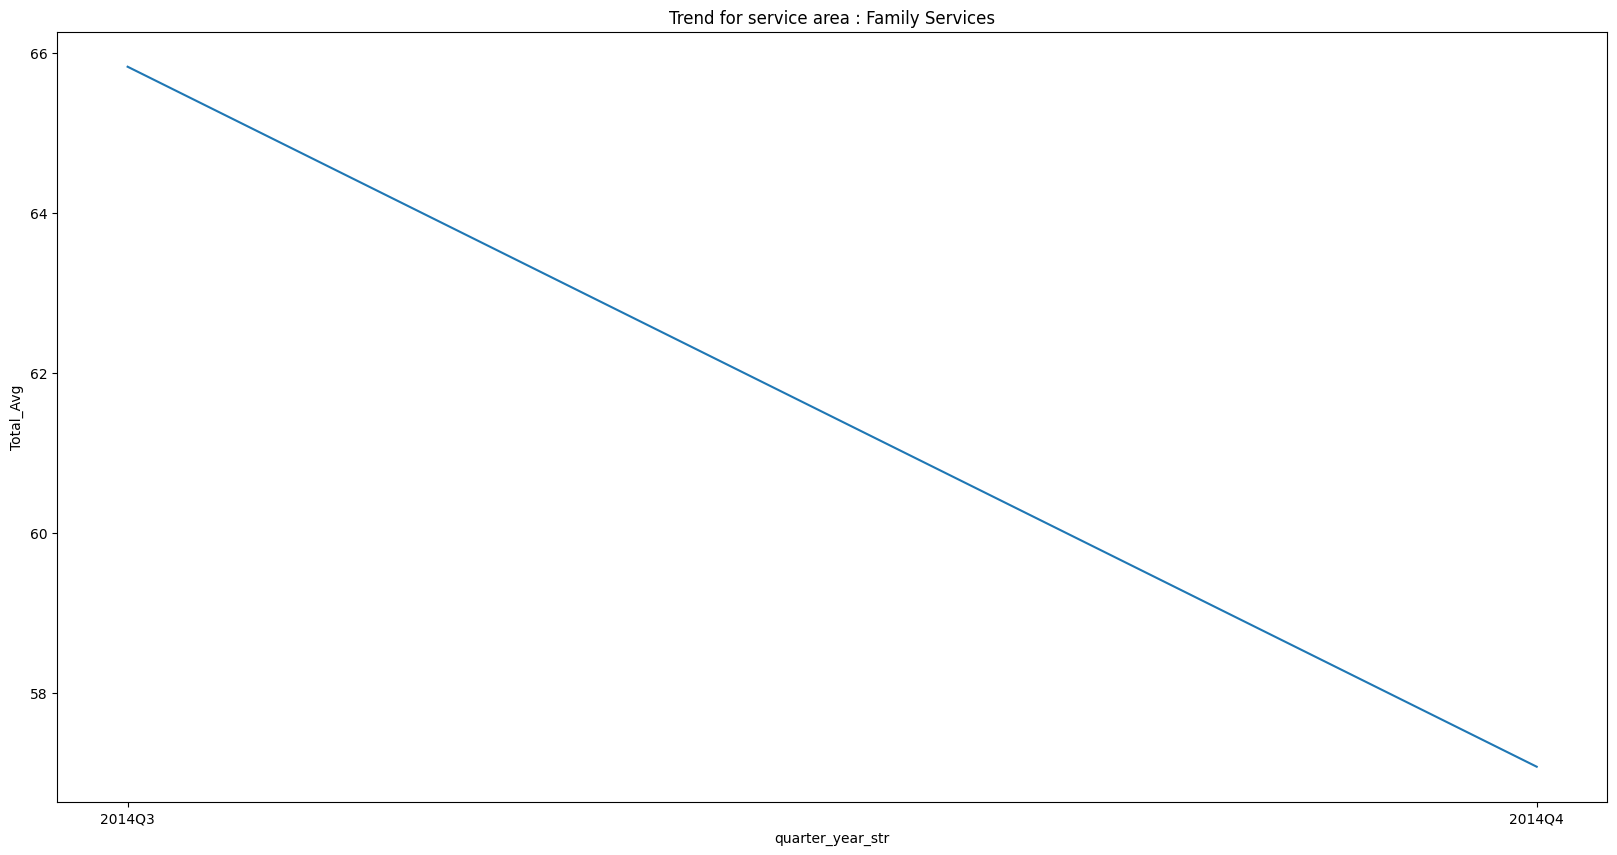

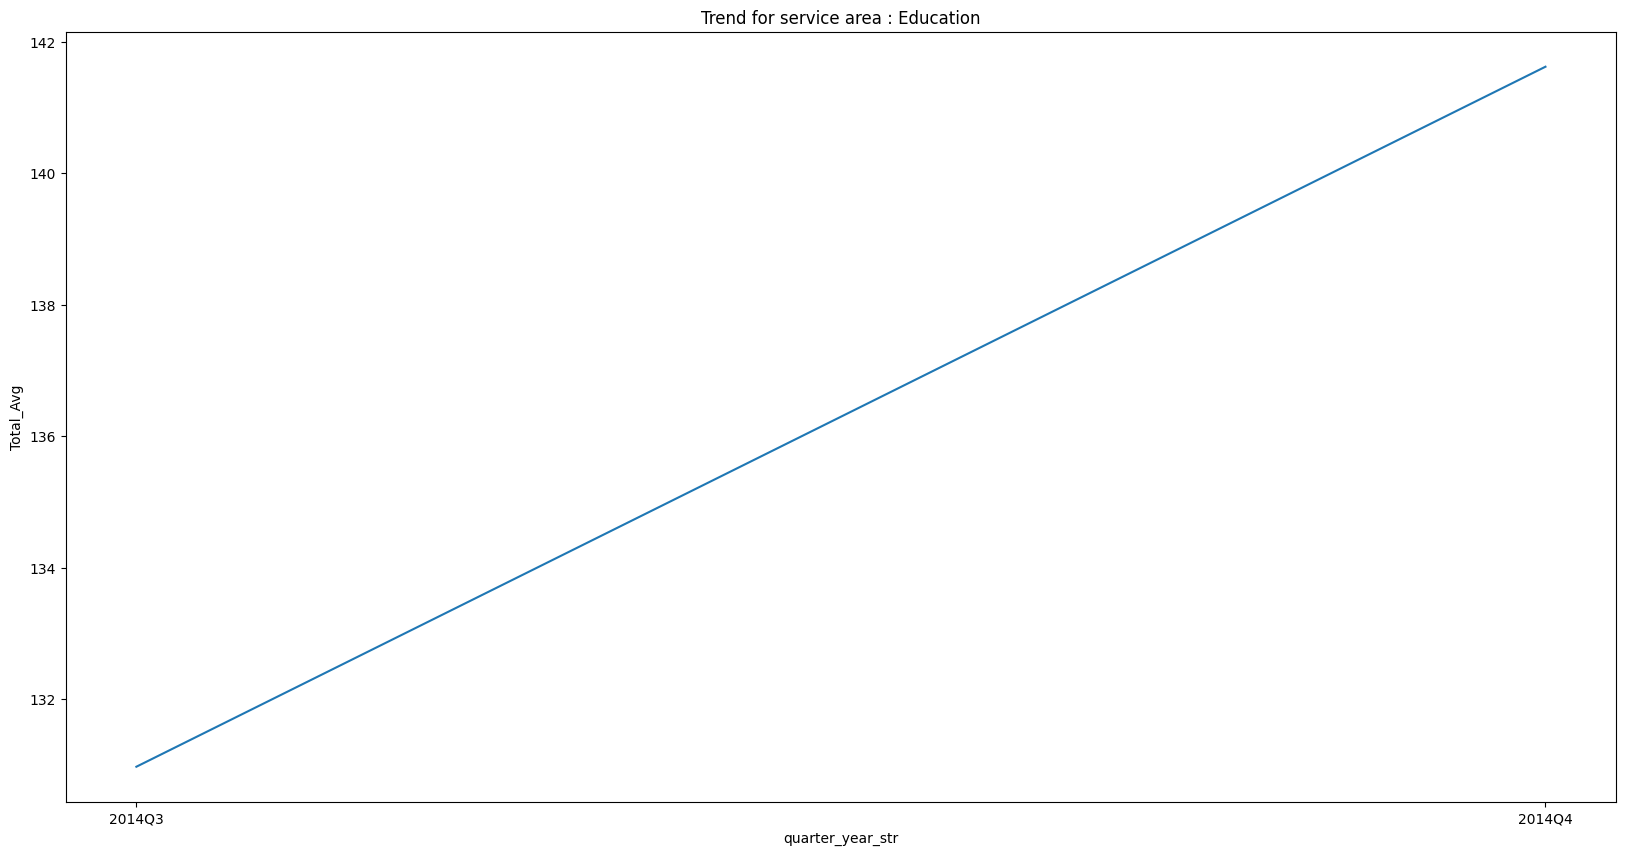

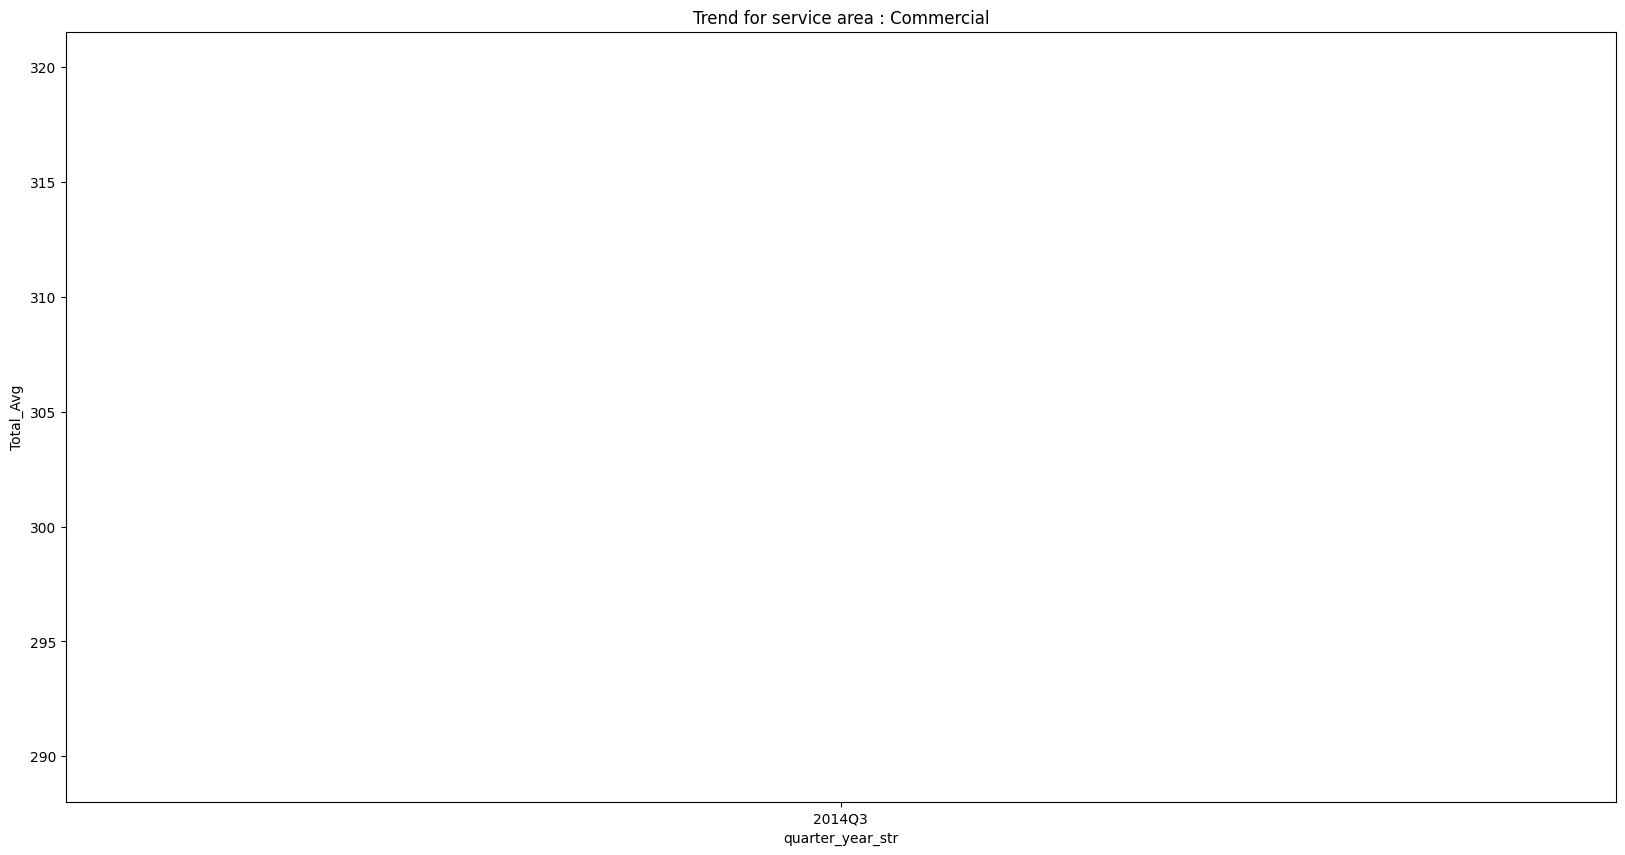

In [43]:
for service in service_list:
    plt.figure(figsize=(20,10))
    service_sub = ts_ds_q_sa[ts_ds_q_sa['Service Area']==service]
    sns.lineplot(x=service_sub['quarter_year_str'],y=service_sub['Total_Avg'])
    plt.title("Trend for service area : {}".format(service))
    plt.show()

Yearly

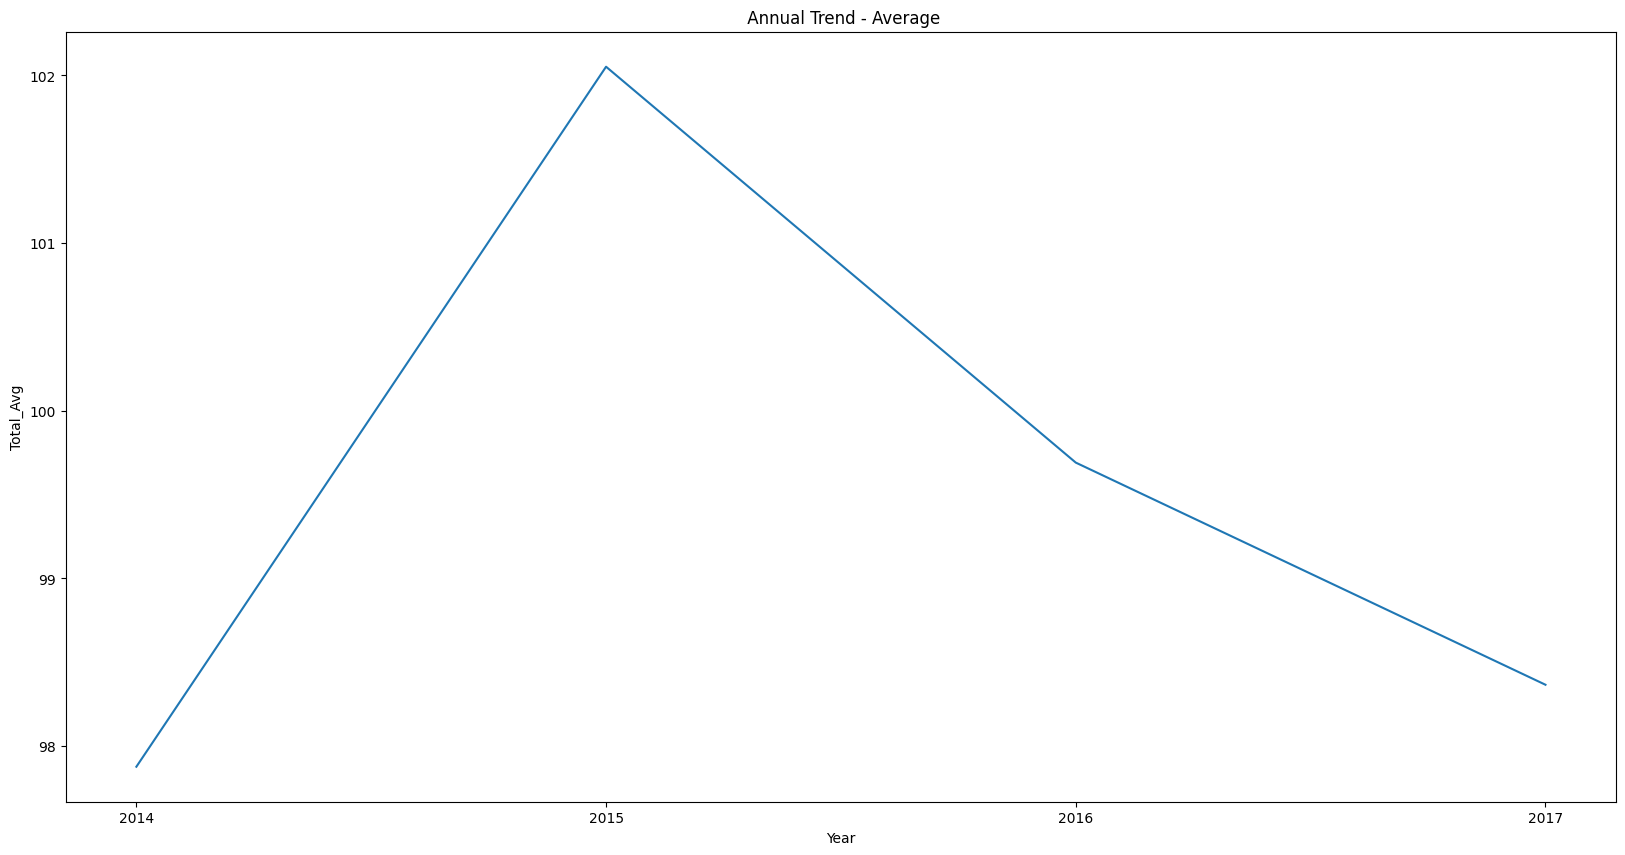

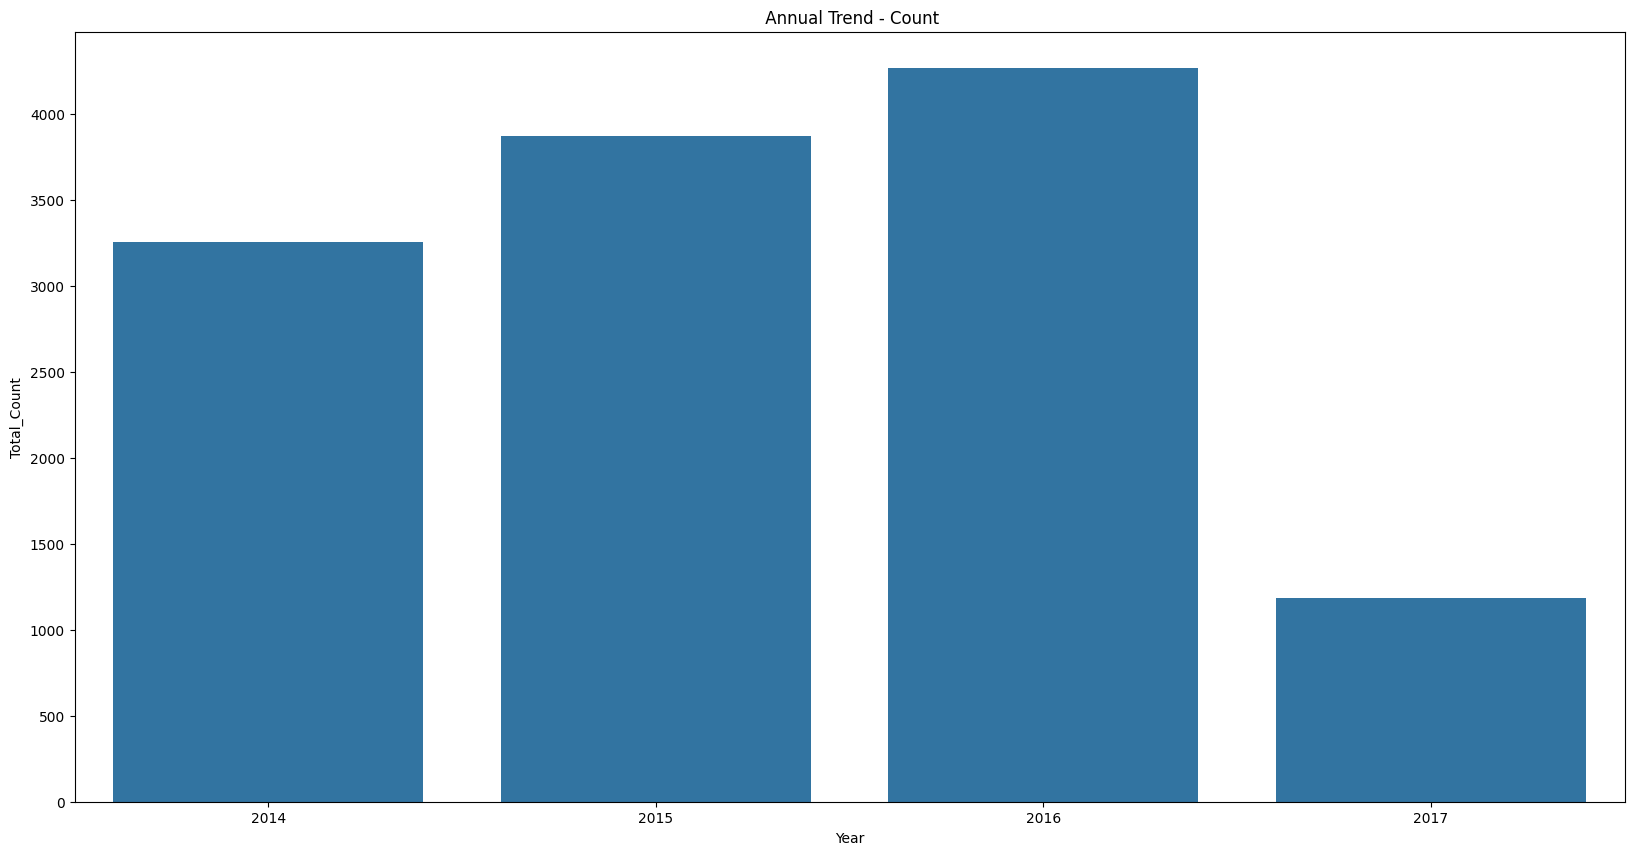

In [52]:
plt.figure(figsize=(20,10))
sns.lineplot(x=ts_ds_y.index,y=ts_ds_y['Total_Avg'])
plt.title(" Annual Trend - Average")
plt.show()
plt.figure(figsize=(20,10))
sns.barplot(x=ts_ds_y.index,y=ts_ds_y['Total_Count'])
plt.title(" Annual Trend - Count")
plt.show()


3. The Auditor would like to get an understanding of how Creditors are classified into accounts. In
particular, they are worried about transaction misclassification. Are you able to identify
instances in which Creditors are not consistently classified into Accounts (e.g., most of the time
Creditor “AirTickets.com” is classified into “Travelling Expenses”, but on some occasions it is also
found in “Miscellaneous”)? 

Let's analyze the different accounts that are related to each creditor.

In [67]:
multi_account_list = []
single_account_list = []
no_account_list = []
creditor_list = ds['Creditor'].unique()
for cred in creditor_list:
    accounts = ds[ds['Creditor']==cred]['Account Description'].nunique()
    if accounts > 1:
        print("The creditor {} is associated with {} Accounts.".format(cred,accounts))
        multi_account_list.append(cred)
    elif accounts < 1:
        print("The creditor {} is associated with NO Accounts.".format(cred))
        no_account_list.append(cred)
    else:
        print("The creditor {} is associated with {} Account.".format(cred,accounts))
        single_account_list.append(cred)
pd.DataFrame({'No_Account_creditors':len(no_account_list),'Single_Account_creditors':len(single_account_list),'Multi_account_creditors':len(multi_account_list)},index=[1])

The creditor AMAZON EU is associated with 18 Accounts.
The creditor AMAZON UK MARKETPLACE is associated with 25 Accounts.
The creditor AMAZON UK RETAIL AMAZO is associated with 15 Accounts.
The creditor WWW.ARGOS.CO.UK is associated with 3 Accounts.
The creditor E.ON ENERGY SOLUTIONS is associated with 3 Accounts.
The creditor AMAZON SVCS EUROPE,SAR is associated with 14 Accounts.
The creditor ARGOS RETAIL GROUP is associated with 10 Accounts.
The creditor CREATESEND/COM is associated with 3 Accounts.
The creditor HOBBYCRAFT (INTERNET) is associated with 1 Accounts.
The creditor NYCOMM LTD is associated with 1 Accounts.
The creditor PMC ELECTRICS LIMI is associated with 1 Accounts.
The creditor W M MORRISON PLC is associated with 2 Accounts.
The creditor WWW.POSNPACK.CO.UK is associated with 1 Accounts.
The creditor LAND REGISTRY is associated with 1 Accounts.
The creditor CROWNE PLAZA LIVERPOOL is associated with 1 Accounts.
The creditor LUL TICKET MACHINE is associated with 9 Account

,No_Account_creditors,Single_Account_creditors,Multi_account_creditors
1,0,1462,474


In [70]:
print("The following creditors are incorrectly classified or associated with multiple accounts")
for account in multi_account_list:
    print("Creditor : {}".format(account))
    cred_list = ds[ds['Creditor']==account]['Account Description'].unique()
    for cred in cred_list:
        print("{}-->{}".format(account,cred))
    print("*"*10)

The following creditors are incorrectly classified or associated with multiple accounts
Creditor : AMAZON EU
AMAZON EU-->Books-CDs-Audio-Video
AMAZON EU-->Equipment and Materials Purcha
AMAZON EU-->Stationery
AMAZON EU-->Training
AMAZON EU-->Miscellaneous Expenses
AMAZON EU-->Building Repairs & Maintenance
AMAZON EU-->Cleaning and domestic material
AMAZON EU-->General Office Expenses
AMAZON EU-->Other Services
AMAZON EU-->Other Transfer Payments to Soc
AMAZON EU-->Professional Services
AMAZON EU-->Publications
AMAZON EU-->Travelling Expenses
AMAZON EU-->E19 - Learning Resources
AMAZON EU-->Education CFR Administrative S
AMAZON EU-->Education CFR Other Occupation
AMAZON EU-->Other Agencies - Third Party P
AMAZON EU-->Equipment and Materials Repair
**********
Creditor : AMAZON UK MARKETPLACE
AMAZON UK MARKETPLACE-->Books-CDs-Audio-Video
AMAZON UK MARKETPLACE-->CSG  - IT
AMAZON UK MARKETPLACE-->Equipment and Materials Purcha
AMAZON UK MARKETPLACE-->Stationery
AMAZON UK MARKETPLACE-->Train

Although, there are certain methods we can undertake to deal with missclassification such as changing account group for creditors having two accounts assuming that the second is misclassified. These methods are not accurate, hence, it's best to consult with the auditor and analyze the report generated above and deal with the misclassification based on the auditor ( domain expert) knowledge.

<hr>

4. In terms of spending behavior (defined by the number and the typical size of transactions), are
there Service Areas that behave similarly and can be grouped together? How?


Taking the two factors into consideration:
1. Number of transactions --> Count
2. Size of transactions --> Average

Experiment:
Let's cluster the quarterly aggregated dataset to understand the underlying

Since, KMeans clustering is a model that relies on calculating distance between datapoints, we have to normalize the data before modelling.

<b> Clustering is an unsupervised learning model , hence we must experiment and analyse to find optimal clustering solution. Unlike supervised learning, we do not have a known performance metric to evaluate model performance</b>

In [152]:
# Kmeans clustering taking no of clusters initially as 4
kmeans = KMeans(n_clusters = 4, random_state = 0, n_init='auto')
kmeans.fit(normalize(ts_ds_q))


KMeans(n_clusters=4, random_state=0)

<Axes: xlabel='Total_Avg', ylabel='Total_Count'>

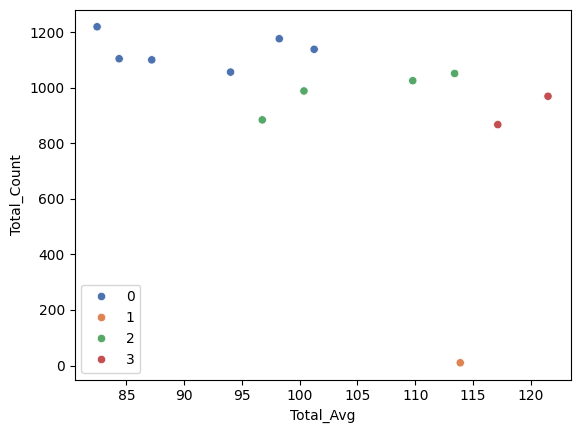

In [130]:
sns.scatterplot(data = ts_ds_q, x = 'Total_Avg', y = 'Total_Count', hue = kmeans.labels_,palette='deep',markers=kmeans.labels_)

Based on thee above plot, we can understand that group 1 is placed furthest from the other clusters and the clusters are more distinguishable based on total average v/s the count.

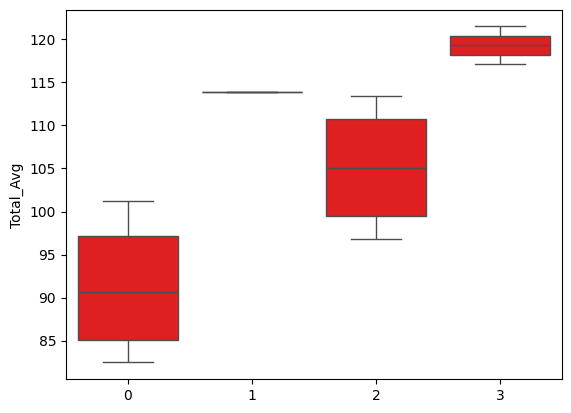

In [135]:
sns.boxplot(x = kmeans.labels_, y = ts_ds_q['Total_Avg'],color='red')
plt.show()

Let's calculate the silhouette score to estimate the optimal number of clusters.

In [136]:
silhouette_score(normalize(ts_ds_q), kmeans.labels_, metric='euclidean')

0.6112099366419693

Choosing the best number of clusters.

In [137]:
K = range(2, 8)
fits = []
score = []


for k in K:
    # train the model for current value of k on training data
    model = KMeans(n_clusters = k, random_state = 0, n_init='auto').fit(normalize(ts_ds_q))
    
    # append the model to fits
    fits.append(model)
    
    # Append the silhouette score to scores
    score.append(silhouette_score(ts_ds_q, model.labels_, metric='euclidean'))

Cluster visualization

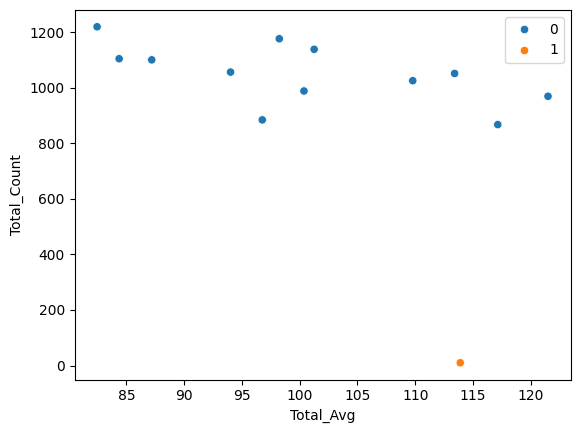

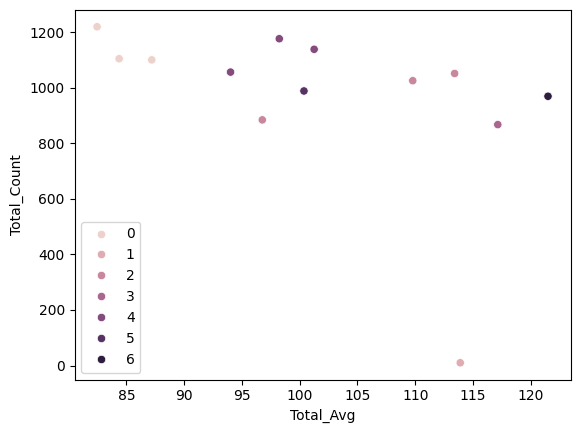

In [146]:
sns.scatterplot(data = ts_ds_q, x = 'Total_Avg', y = 'Total_Count', hue = fits[0].labels_) # number of cluster =2
plt.show()
sns.scatterplot(data = ts_ds_q, x = 'Total_Avg', y = 'Total_Count', hue = fits[-1].labels_) # number of cluster =8
plt.show()

<Axes: >

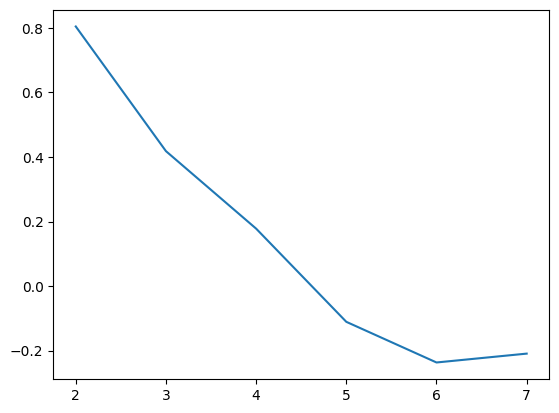

In [153]:
sns.lineplot(x = K, y = score) # silhoutte score line plot

We can notice that there is an elbow point ( point of sudden change in score) at cluster number 5 and 6.

<Axes: ylabel='Total_Avg'>

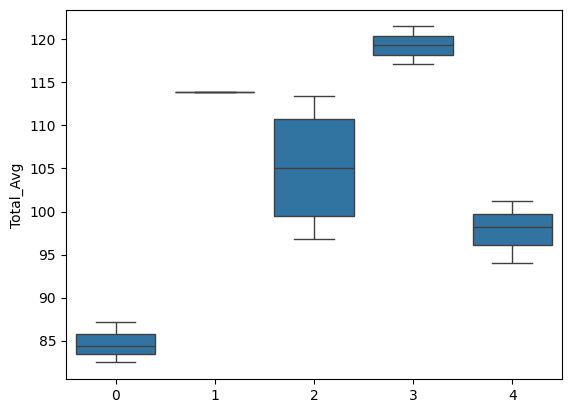

In [151]:
sns.boxplot(x = fits[3].labels_, y = ts_ds_q['Total_Avg'])

Result: The above experiment is performed on quarterly data. The factors of clustering are total average/quarter and count of transactions/quarter. From the results, we can understand that clustering with 5 clusters show best results.

The interaction or relation with service area feature can not be estimated accurately, because have taken the univariate quarterly dataset ( does not contain service area feature or service area based quantization).

<hr><br>
5. The auditor has heard that you may know anomaly detection techniques. They would like to ask
you for a sample of a few hundred transactions that are anomalous, different or worthwhile
inquiring about. The sample should include at least five transactions for each Service Area.
Please provide this sample and explain why they are special or different.

Anomalies, often referred to as outliers, abnormalities, rare events, or deviants, are data points or patterns in data that do not conform to a notion of normal behavior. Anomaly detection, then, is the task of finding those patterns in data that do not adhere to expected norms, given previous observations. The capability to recognize or detect anomalous behavior can provide highly useful insights across industries. Flagging unusual cases or enacting a planned response when they occur can save businesses time, costs, and customers. Hence, anomaly detection has found diverse applications in a variety of domains, including IT analytics, network intrusion analytics, medical diagnostics, financial fraud protection, manufacturing quality control, marketing and social media analytics, and more. 

That said, for many anomaly detection use cases, the proportion of normal versus anomalous examples is highly imbalanced; while there may be multiple anomalous classes, each could be quite underrepresented. 

Solution: Although there are multiple strategies to implement anomaly detection, we will be considering subsets of original dataset and untransformed dataset for training the models. Training the model on a subset of data with only samples belonging to a certain service area will help us to find anomalies specific to that service area. By adopting this approach, we will have to train a model specific for that service area transaction. 

If there is a situation, where we do not know if a data point belongs to a specific service area we can evaluate that data point on a model trained on the dataset containing samples from all service areas.

<b> We will be utilizing the Isolation Forest Anomaly Detection model for this experiment</b>

In [160]:
main_ds = ts_ds[['Journal Date','Service Area','Total']]

In [163]:
main_ds.shape

(12587, 3)

In [169]:
model=IsolationForest(n_estimators=120, max_samples=12000, contamination=float(0.1),max_features=1.0)
model.fit(main_ds[['Total']])

IsolationForest(contamination=0.1, max_samples=12000, n_estimators=120)

In [170]:
# Getting the anomaly scores and results
main_ds['scores']=model.decision_function(main_ds[['Total']])
main_ds['anomaly']=model.predict(main_ds[['Total']])

C:\Users\shara\AppData\Local\Temp\ipykernel_27512\2323514717.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\shara\AppData\Local\Temp\ipykernel_27512\2323514717.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



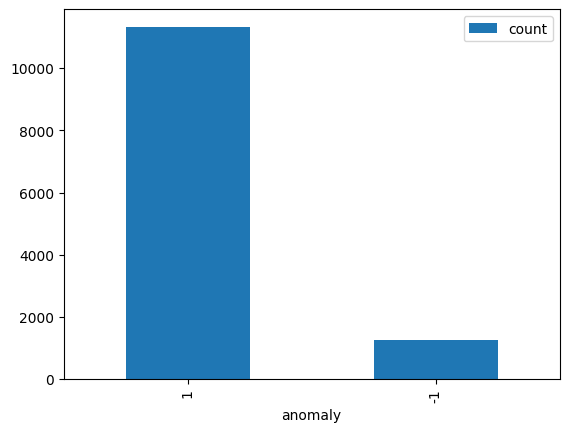

In [174]:
main_ds['anomaly'].value_counts().plot(kind='bar')
plt.legend()

#### Simulating anomaly detection on test dataset

Let's use the file named 1718Pcard.csv, which has different column names but transactions present in it.

In [192]:
test_ds = pd.read_csv('Data/1718Pcard.csv')

In [194]:
test_ds.rename(columns={'FIN.TRANSACTION AMOUNT':'Total'},inplace=True)
test_ds = test_ds[['Total']]

In [196]:
test_ds['Total'] = test_ds['Total'].apply(digit_clean)

C:\Users\shara\AppData\Local\Temp\ipykernel_27512\1863812730.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [197]:
test_ds['scores']=model.decision_function(test_ds[['Total']])
test_ds['anomaly']=model.predict(test_ds[['Total']])

C:\Users\shara\AppData\Local\Temp\ipykernel_27512\1177512589.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\shara\AppData\Local\Temp\ipykernel_27512\1177512589.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



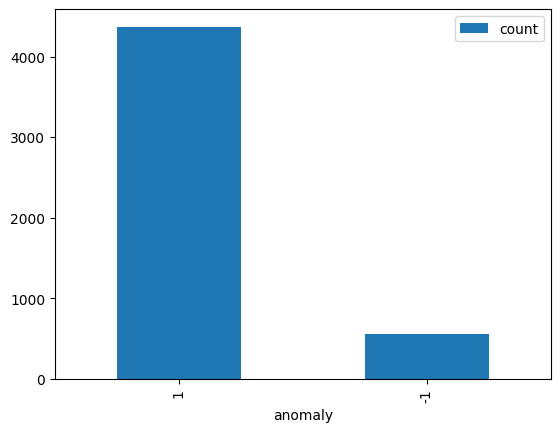

In [201]:
test_ds['anomaly'].value_counts().plot(kind='bar')
plt.legend()
plt.show()

In [203]:
test_ds[test_ds['anomaly']==-1].head(10)

,Total,scores,anomaly
12,-22.79,-0.016823,-1
16,338.95,-0.042553,-1
21,355.00,-0.050625,-1
23,620.92,-0.145242,-1
27,319.97,-0.053818,-1
28,718.95,-0.113679,-1
32,375.00,-0.042013,-1
33,344.98,-0.044494,-1
35,-48.50,-0.055877,-1
48,438.00,-0.060996,-1


List of anomalies detected based on amount.

Now training model specific to service area.

In [212]:
def anomaly_report(service_area):
    # Create subset from dataset for specified service_area
    sub_ds = main_ds[main_ds['Service Area']==service_area]
    # Train anomaly model
    model=IsolationForest(n_estimators=120, max_samples='auto', contamination=float(0.1),max_features=1.0)
    model.fit(sub_ds[['Total']])
    # Detect anomalies on subset
    sub_ds['scores']=model.decision_function(sub_ds[['Total']])
    sub_ds['anomaly']=model.predict(sub_ds[['Total']])
    return(sub_ds[sub_ds['anomaly']==-1].head(5))

In [214]:
for service in service_list:
    print(anomaly_report(service))
    print("*"*50)

   Journal Date            Service Area    Total    scores  anomaly
7    2017-01-11  Adults and Communities  3569.03 -0.331281       -1
39   2016-12-09  Adults and Communities   830.00 -0.007879       -1
40   2016-11-22  Adults and Communities  1670.30 -0.194399       -1
41   2016-11-22  Adults and Communities  1625.00 -0.188299       -1
42   2016-11-29  Adults and Communities   830.00 -0.007879       -1
**************************************************
    Journal Date Service Area   Total    scores  anomaly
176   2016-11-02    Assurance  117.89 -0.014146       -1
180   2016-04-06    Assurance  304.02 -0.037991       -1
183   2017-03-20    Assurance  253.35 -0.022266       -1
188   2016-05-11    Assurance  290.00 -0.023983       -1
189   2016-07-15    Assurance  370.00 -0.077127       -1
**************************************************
    Journal Date                   Service Area   Total    scores  anomaly
363   2016-11-09  Children's Education & Skills  500.00 -0.077793       -